#### Optimal Opponent Experiments
Author: Yemi Kelani

##### Google Drive Setup (Skip if running locally)

> To run this notebook, follow these steps:
> 1. Download the latest version of the [repository](https://github.com/yemi-kelani/artificial-intelligence/tree/master).
> 2. Upload the repsitory files to your Google Drive account under the path `Projects/artificial-intelligence`.
> 3. Open this file (`train.ipynb`) from your Google Drive and run the experiments.

##### Local Setup (Skip if running remotely)

> 1. Run the following cells

In [10]:
# Google Colab Setup (Skip if running locally)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    RUNNING_ON_COLAB = True
    print("✓ Google Colab detected and drive mounted")
except ImportError:
    RUNNING_ON_COLAB = False
    print("✓ Running locally")

✓ Running locally


In [11]:
# Import modules based on environment
import sys
import os

if RUNNING_ON_COLAB:
    # Copy files to local directory for import
    !cp {PROJECT_PATH}/DeepQAgent.py .
    !cp {PROJECT_PATH}/TicTacToeGame.py .
    !cp {ROOT_FOLDER}/Utils.py .
    
    # Import from local copies
    from DeepQAgent import DeepQAgent
    from TicTacToeGame import TicTacToeGame, OPPONENT_LEVEL
    from Utils import train_agent, test_agent, set_seed
    print("✓ Colab imports completed")
else:
    # Add parent directories to path for local imports
    sys.path.append(os.path.abspath(os.path.join('..', '..')))
    sys.path.append(os.path.abspath(os.path.join('..', '..', '..')))
    
    # Import from proper module structure
    from models.ReinforcementLearning.DeepQ_TicTacToe_v2.DeepQAgent import DeepQAgent
    from models.ReinforcementLearning.DeepQ_TicTacToe_v2.TicTacToeGame import TicTacToeGame, OPPONENT_LEVEL
    from models.ReinforcementLearning.Utils import train_agent, test_agent, set_seed
    print("✓ Local imports completed")

# Verify imports worked
print(f"✓ DeepQAgent version: {DeepQAgent.__version__}")
print(f"✓ TicTacToeGame version: {TicTacToeGame.__version__}")

✓ Local imports completed
✓ DeepQAgent version: 2.0
✓ TicTacToeGame version: 2.0


##### Experiments

In [12]:
import os
import torch
import numpy as np
from datetime import datetime

# Set seeds for reproducibility
RANDOM_SEED = 42
set_seed(RANDOM_SEED)
print(f"✓ Random seed set to {RANDOM_SEED}")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✓ Using device: {DEVICE}")

# Optimized DQN Hyperparameters
LEARNING_RATE = 0.001
NUM_EPISODES = 100000
EPSILON = 1.0
GAMMA = 0.99
STATE_SPACE = 9
ACTION_SPACE = 9
HIDDEN_SIZE = 256
DROPOUT = 0.1
TRAIN_START = 500  # Lower for faster initial learning
BATCH_SIZE = 64
MEMORY_MAX_LEN = 10000
USE_TARGET_NETWORK = True
NETWORK_SYNC_RATE = 100

# Experiment configuration
SAVE_FREQUENCY = 5000  # Save every 5K episodes
TEST_FREQUENCY = 10000  # Test every 10K episodes
VALIDATION_EPISODES = 1000  # Episodes for validation testing

# Get the project root directory dynamically
# The notebook is at: models/ReinforcementLearning/DeepQ_TicTacToe_v2/experiments/
NOTEBOOK_DIR = os.path.dirname(os.path.abspath("__file__"))
PROJECT_ROOT = os.path.abspath(os.path.join(NOTEBOOK_DIR, "..", "..", "..", ".."))
MODEL_PATH = os.path.join(PROJECT_ROOT, "trained_models", "ReinforcementLearning", "TicTacToeV2")

# Ensure the directory exists
os.makedirs(MODEL_PATH, exist_ok=True)
print(f"✓ Model save path: {MODEL_PATH}")

print("✓ Hyperparameters configured:")
print(f"  - Episodes: {NUM_EPISODES:,}")
print(f"  - Learning Rate: {LEARNING_RATE}")
print(f"  - Hidden Size: {HIDDEN_SIZE}")
print(f"  - Batch Size: {BATCH_SIZE}")
print(f"  - Memory Size: {MEMORY_MAX_LEN:,}")
print(f"  - Train Start: {TRAIN_START}")

# Model naming convention
BASELINE = "TicTacToe-v2-BASELINE"
NAIVE    = "TicTacToe-v2-NAIVE"
AGENT    = "TicTacToe-v2-AGENT"
OPTIMAL  = "TicTacToe-v2-OPTIMAL"
SELF     = "TicTacToe-v2-SELF"

def get_full_model_path(agent_name: str = ""):
    """Get full path for model file with proper validation."""
    if agent_name == "":
        return os.path.join(MODEL_PATH, "DQN_checkpoint.pt") 
    return os.path.join(MODEL_PATH, agent_name + ".pt")

def supply_model(
    load_if_exists: bool = True, 
    agent_name: str = "",
    optimizer_type: str = "ADAM"
):
    """Create and configure agent with proper initialization."""
    
    print(f"Creating agent with configuration:")
    print(f"  - Device: {DEVICE}")
    print(f"  - Optimizer: {optimizer_type}")
    print(f"  - Load existing: {load_if_exists}")
    
    agent = DeepQAgent(
        device             = DEVICE,
        epsilon            = EPSILON,
        gamma              = GAMMA,
        state_space        = STATE_SPACE,
        action_space       = ACTION_SPACE,
        hidden_size        = HIDDEN_SIZE,
        dropout            = DROPOUT,
        train_start        = TRAIN_START,
        batch_size         = BATCH_SIZE,
        memory_max_len     = MEMORY_MAX_LEN,
        use_target_network = USE_TARGET_NETWORK,
        network_sync_rate  = NETWORK_SYNC_RATE
    )
    
    # Load existing model if requested and available
    full_model_path = get_full_model_path(agent_name)
    if load_if_exists and os.path.exists(full_model_path):
        try:
            print(f"Loading model from: {full_model_path}")
            agent.load_model(filepath=full_model_path, weights_only=True)
            print("✓ Model loaded successfully")
        except Exception as e:
            print(f"⚠ Failed to load model: {e}")
            print("Continuing with fresh initialization...")

    # Create optimizer
    optimizer_configs = {
        "SGD": lambda: torch.optim.SGD(
            agent.policy_network.parameters(), 
            lr=LEARNING_RATE, 
            momentum=0.9
        ),
        "RMS": lambda: torch.optim.RMSprop(
            agent.policy_network.parameters(), 
            lr=LEARNING_RATE
        ),
        "ADAM": lambda: torch.optim.Adam(
            agent.policy_network.parameters(), 
            lr=LEARNING_RATE
        ),
        "ADAMW": lambda: torch.optim.AdamW(
            agent.policy_network.parameters(), 
            lr=LEARNING_RATE
        )
    }
    
    optimizer_key = optimizer_type.upper()
    if optimizer_key in optimizer_configs:
        optimizer = optimizer_configs[optimizer_key]()
        print(f"✓ {optimizer_key} optimizer created")
    else:
        print(f"⚠ Unknown optimizer '{optimizer_type}', defaulting to Adam")
        optimizer = optimizer_configs["ADAM"]()
        
    criterion = torch.nn.MSELoss()
    
    return agent, optimizer, criterion

def validate_agent_performance(agent_name: str, num_episodes: int = VALIDATION_EPISODES):
    """Comprehensive validation against different opponent types."""
    print(f"\n=== Validating {agent_name} Performance ===")
    
    try:
        agent, _, _ = supply_model(load_if_exists=True, agent_name=agent_name)
        
        # Test against NAIVE opponent
        print("\nTesting against NAIVE opponent...")
        environment_naive = TicTacToeGame(DEVICE, None, OPPONENT_LEVEL.NAIVE, start_as_X=True)
        results_naive = test_agent(agent, environment_naive, num_episodes, print_state=False)
        
        # Test against OPTIMAL opponent
        print("\nTesting against OPTIMAL opponent...")
        environment_optimal = TicTacToeGame(DEVICE, None, OPPONENT_LEVEL.OPTIMAL, start_as_X=True)
        results_optimal = test_agent(agent, environment_optimal, min(num_episodes//10, 100), print_state=False)
        
        return {
            'naive': results_naive,
            'optimal': results_optimal
        }
        
    except Exception as e:
        print(f"❌ Validation failed: {e}")
        return None

print("✓ Helper functions defined")
print("✓ Ready for training experiments")

✓ Random seed set to 42
✓ Using device: cpu
✓ Model save path: /Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2
✓ Hyperparameters configured:
  - Episodes: 100,000
  - Learning Rate: 0.001
  - Hidden Size: 256
  - Batch Size: 64
  - Memory Size: 10,000
  - Train Start: 500
✓ Helper functions defined
✓ Ready for training experiments


In [13]:
# Quick sanity check for game mechanics
def verify_game_mechanics():
    """Verify basic game mechanics are working correctly."""
    test_env = TicTacToeGame(DEVICE, None, OPPONENT_LEVEL.NAIVE, start_as_X=True)
    test_env.reset_board()
    test_env.board = torch.tensor([[-1,-1,0], [0,1,0], [1,0,0]])
    
    reward, done, winner = test_env.is_game_over()
    
    # X should not have won yet (only 2 in a row)
    assert not done, "Game should not be over"
    assert winner is None, "No winner yet"
    print("✓ Game mechanics verified correctly")
    return True

# Run verification
verify_game_mechanics()

✓ Game mechanics verified correctly


True

In [14]:
# Create and save baseline model
print("=== Creating Baseline Model ===")
agent, _, _ = supply_model(load_if_exists=False)  # Fresh model
baseline_path = agent.save_model(MODEL_PATH, BASELINE)
print(f"✓ Baseline model saved to: {baseline_path}")

# Validate baseline is random
print("\nValidating baseline performance (should be ~random):")
baseline_results = validate_agent_performance(BASELINE, num_episodes=100)
if baseline_results:
    print("✓ Baseline validation complete")

2025-12-05 15:58:11 - DeepQAgent - INFO - Model saved to '/Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-BASELINE.pt'.
/Users/yemikelani/Projects/artificial-intelligence/.venv/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
2025-12-05 15:58:11 - DeepQAgent - INFO - Model loaded from '/Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-BASELINE.pt'.


=== Creating Baseline Model ===
Creating agent with configuration:
  - Device: cpu
  - Optimizer: ADAM
  - Load existing: False
✓ ADAM optimizer created
✓ Baseline model saved to: /Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-BASELINE.pt

Validating baseline performance (should be ~random):

=== Validating TicTacToe-v2-BASELINE Performance ===
Creating agent with configuration:
  - Device: cpu
  - Optimizer: ADAM
  - Load existing: True
Loading model from: /Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-BASELINE.pt
✓ Model loaded successfully
✓ ADAM optimizer created

Testing against NAIVE opponent...


100%|██████████| 100/100 [00:00<00:00, 623.19it/s]



Results as X (50 games):
Win rate:  58.00% (29/50)
Draw rate: 20.00% (10/50)
Loss rate: 22.00% (11/50)
Avg reward: 0.64


Results as O (50 games):
Win rate:  28.00% (14/50)
Draw rate: 10.00% (5/50)
Loss rate: 62.00% (31/50)
Avg reward: 0.28


Overall Statistics:
Total games: 100
Overall win rate: 43.00%
Average game length: 3.8 moves
Game length std: 0.8

Testing against OPTIMAL opponent...


100%|██████████| 10/10 [00:03<00:00,  2.74it/s]


Results as X (5 games):
Win rate:  0.00% (0/5)
Draw rate: 100.00% (5/5)
Loss rate: 0.00% (0/5)
Avg reward: 0.30


Results as O (5 games):
Win rate:  0.00% (0/5)
Draw rate: 0.00% (0/5)
Loss rate: 100.00% (5/5)
Avg reward: 0.00


Overall Statistics:
Total games: 10
Overall win rate: 0.00%
Average game length: 3.9 moves
Game length std: 1.1
✓ Baseline validation complete


In [15]:
# Quick baseline test
print("=== Quick Baseline Test ===")
baseline_results = validate_agent_performance(BASELINE, num_episodes=100)
print("✓ Baseline test complete")

2025-12-05 15:58:52 - DeepQAgent - INFO - Model loaded from '/Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-BASELINE.pt'.


=== Quick Baseline Test ===

=== Validating TicTacToe-v2-BASELINE Performance ===
Creating agent with configuration:
  - Device: cpu
  - Optimizer: ADAM
  - Load existing: True
Loading model from: /Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-BASELINE.pt
✓ Model loaded successfully
✓ ADAM optimizer created

Testing against NAIVE opponent...


100%|██████████| 100/100 [00:00<00:00, 584.07it/s]



Results as X (50 games):
Win rate:  74.00% (37/50)
Draw rate: 18.00% (9/50)
Loss rate: 8.00% (4/50)
Avg reward: 0.79


Results as O (50 games):
Win rate:  22.00% (11/50)
Draw rate: 12.00% (6/50)
Loss rate: 66.00% (33/50)
Avg reward: 0.22


Overall Statistics:
Total games: 100
Overall win rate: 48.00%
Average game length: 3.8 moves
Game length std: 0.8

Testing against OPTIMAL opponent...


100%|██████████| 10/10 [00:04<00:00,  2.37it/s]


Results as X (5 games):
Win rate:  0.00% (0/5)
Draw rate: 100.00% (5/5)
Loss rate: 0.00% (0/5)
Avg reward: 0.30


Results as O (5 games):
Win rate:  0.00% (0/5)
Draw rate: 0.00% (0/5)
Loss rate: 100.00% (5/5)
Avg reward: 0.00


Overall Statistics:
Total games: 10
Overall win rate: 0.00%
Average game length: 4.0 moves
Game length std: 1.1
✓ Baseline test complete


2025-12-05 15:59:12 - DeepQAgent - INFO - Model loaded from '/Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-BASELINE.pt'.


=== EXPERIMENT 1: Training Against NAIVE Opponent ===
Creating agent with configuration:
  - Device: cpu
  - Optimizer: ADAM
  - Load existing: True
Loading model from: /Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-BASELINE.pt
✓ Model loaded successfully
✓ ADAM optimizer created
✓ Agent configured:
  - Epsilon: 1.000
  - Training episodes: 50,000
  - Cosine annealing: 0.001 to 1.000
✓ Environment configured against naive opponent

Starting training against NAIVE opponent...
[0010/50000] Steps: 4 Reward: -1.00, Loss: 0.0000 Epsilon: 1.0000, Role: O Win: 30.00% Draw: 0.00% Loss: 70.00%
[0020/50000] Steps: 4 Reward: 0.30, Loss: 0.0000 Epsilon: 1.0000, Role: O Win: 35.00% Draw: 10.00% Loss: 55.00%
[0030/50000] Steps: 4 Reward: 1.00, Loss: 0.0000 Epsilon: 1.0000, Role: O Win: 36.67% Draw: 10.00% Loss: 53.33%
[0040/50000] Steps: 3 Reward: 1.00, Loss: 0.0000 Epsilon: 1.0000, Role: O Win: 37.50% Draw: 7.50% Loss: 55.00%
[0050/5

2025-12-05 16:06:54 - DeepQAgent - INFO - Model saved to '/Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-NAIVE-5K.pt'.


[5010/50000] Steps: 3 Reward: -1.00, Loss: 0.0175 Epsilon: 0.9757, Role: O Win: 43.69% Draw: 12.46% Loss: 43.85%
[5020/50000] Steps: 4 Reward: -1.00, Loss: 0.0128 Epsilon: 0.9756, Role: O Win: 43.67% Draw: 12.45% Loss: 43.88%
[5030/50000] Steps: 4 Reward: 1.00, Loss: 0.0145 Epsilon: 0.9755, Role: O Win: 43.64% Draw: 12.45% Loss: 43.92%
[5040/50000] Steps: 3 Reward: -1.00, Loss: 0.0165 Epsilon: 0.9754, Role: O Win: 43.65% Draw: 12.44% Loss: 43.91%
[5050/50000] Steps: 4 Reward: 0.30, Loss: 0.0196 Epsilon: 0.9753, Role: O Win: 43.60% Draw: 12.48% Loss: 43.92%
[5060/50000] Steps: 4 Reward: -1.00, Loss: 0.0151 Epsilon: 0.9752, Role: O Win: 43.58% Draw: 12.47% Loss: 43.95%
[5070/50000] Steps: 4 Reward: 1.00, Loss: 0.0139 Epsilon: 0.9751, Role: O Win: 43.57% Draw: 12.49% Loss: 43.94%
[5080/50000] Steps: 3 Reward: -1.00, Loss: 0.0156 Epsilon: 0.9750, Role: O Win: 43.52% Draw: 12.48% Loss: 44.00%
[5090/50000] Steps: 3 Reward: -1.00, Loss: 0.0181 Epsilon: 0.9749, Role: O Win: 43.52% Draw: 12.51%

2025-12-05 16:14:24 - DeepQAgent - INFO - Model saved to '/Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-NAIVE-10K.pt'.


[10010/50000] Steps: 4 Reward: 1.00, Loss: 0.0105 Epsilon: 0.9053, Role: O Win: 45.47% Draw: 12.16% Loss: 42.37%
[10020/50000] Steps: 4 Reward: 0.30, Loss: 0.0157 Epsilon: 0.9051, Role: O Win: 45.47% Draw: 12.19% Loss: 42.35%
[10030/50000] Steps: 4 Reward: 1.00, Loss: 0.0160 Epsilon: 0.9050, Role: O Win: 45.45% Draw: 12.17% Loss: 42.37%
[10040/50000] Steps: 3 Reward: -1.00, Loss: 0.0101 Epsilon: 0.9048, Role: O Win: 45.48% Draw: 12.16% Loss: 42.36%
[10050/50000] Steps: 4 Reward: 1.00, Loss: 0.0143 Epsilon: 0.9046, Role: O Win: 45.47% Draw: 12.16% Loss: 42.37%
[10060/50000] Steps: 4 Reward: -1.00, Loss: 0.0127 Epsilon: 0.9044, Role: O Win: 45.48% Draw: 12.17% Loss: 42.36%
[10070/50000] Steps: 4 Reward: 1.00, Loss: 0.0163 Epsilon: 0.9042, Role: O Win: 45.49% Draw: 12.16% Loss: 42.34%
[10080/50000] Steps: 3 Reward: 1.00, Loss: 0.0108 Epsilon: 0.9040, Role: O Win: 45.51% Draw: 12.16% Loss: 42.33%
[10090/50000] Steps: 3 Reward: 1.00, Loss: 0.0135 Epsilon: 0.9038, Role: O Win: 45.51% Draw: 1

2025-12-05 16:21:47 - DeepQAgent - INFO - Model saved to '/Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-NAIVE-15K.pt'.


[15010/50000] Steps: 4 Reward: 1.00, Loss: 0.0101 Epsilon: 0.7958, Role: O Win: 46.85% Draw: 12.37% Loss: 40.79%
[15020/50000] Steps: 4 Reward: -1.00, Loss: 0.0105 Epsilon: 0.7955, Role: O Win: 46.85% Draw: 12.36% Loss: 40.79%
[15030/50000] Steps: 4 Reward: 0.30, Loss: 0.0125 Epsilon: 0.7952, Role: O Win: 46.85% Draw: 12.36% Loss: 40.79%
[15040/50000] Steps: 3 Reward: -1.00, Loss: 0.0149 Epsilon: 0.7950, Role: O Win: 46.85% Draw: 12.37% Loss: 40.78%
[15050/50000] Steps: 4 Reward: 0.30, Loss: 0.0120 Epsilon: 0.7947, Role: O Win: 46.85% Draw: 12.37% Loss: 40.78%
[15060/50000] Steps: 3 Reward: 1.00, Loss: 0.0145 Epsilon: 0.7945, Role: O Win: 46.86% Draw: 12.37% Loss: 40.77%
[15070/50000] Steps: 4 Reward: -1.00, Loss: 0.0136 Epsilon: 0.7942, Role: O Win: 46.86% Draw: 12.36% Loss: 40.78%
[15080/50000] Steps: 4 Reward: 0.30, Loss: 0.0104 Epsilon: 0.7940, Role: O Win: 46.85% Draw: 12.37% Loss: 40.78%
[15090/50000] Steps: 3 Reward: -1.00, Loss: 0.0166 Epsilon: 0.7937, Role: O Win: 46.84% Draw:

2025-12-05 16:28:59 - DeepQAgent - INFO - Model saved to '/Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-NAIVE-20K.pt'.


[20010/50000] Steps: 4 Reward: 0.30, Loss: 0.0073 Epsilon: 0.6577, Role: O Win: 48.83% Draw: 12.22% Loss: 38.95%
[20020/50000] Steps: 4 Reward: -1.00, Loss: 0.0095 Epsilon: 0.6574, Role: O Win: 48.83% Draw: 12.22% Loss: 38.96%
[20030/50000] Steps: 4 Reward: 0.30, Loss: 0.0099 Epsilon: 0.6571, Role: O Win: 48.84% Draw: 12.22% Loss: 38.95%
[20040/50000] Steps: 4 Reward: 1.00, Loss: 0.0112 Epsilon: 0.6568, Role: O Win: 48.84% Draw: 12.22% Loss: 38.94%
[20050/50000] Steps: 3 Reward: -1.00, Loss: 0.0107 Epsilon: 0.6565, Role: O Win: 48.86% Draw: 12.21% Loss: 38.93%
[20060/50000] Steps: 3 Reward: 1.00, Loss: 0.0122 Epsilon: 0.6562, Role: O Win: 48.87% Draw: 12.22% Loss: 38.91%
[20070/50000] Steps: 4 Reward: 0.30, Loss: 0.0086 Epsilon: 0.6560, Role: O Win: 48.87% Draw: 12.23% Loss: 38.89%
[20080/50000] Steps: 4 Reward: 1.00, Loss: 0.0083 Epsilon: 0.6557, Role: O Win: 48.88% Draw: 12.24% Loss: 38.88%
[20090/50000] Steps: 4 Reward: 0.30, Loss: 0.0139 Epsilon: 0.6554, Role: O Win: 48.87% Draw: 1

2025-12-05 16:36:04 - DeepQAgent - INFO - Model saved to '/Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-NAIVE-25K.pt'.


[25010/50000] Steps: 4 Reward: -1.00, Loss: 0.0126 Epsilon: 0.5048, Role: O Win: 51.48% Draw: 11.99% Loss: 36.53%
[25020/50000] Steps: 3 Reward: -1.00, Loss: 0.0120 Epsilon: 0.5044, Role: O Win: 51.49% Draw: 11.98% Loss: 36.53%
[25030/50000] Steps: 4 Reward: 1.00, Loss: 0.0077 Epsilon: 0.5041, Role: O Win: 51.50% Draw: 11.98% Loss: 36.52%
[25040/50000] Steps: 3 Reward: 1.00, Loss: 0.0113 Epsilon: 0.5038, Role: O Win: 51.50% Draw: 11.98% Loss: 36.52%
[25050/50000] Steps: 3 Reward: 1.00, Loss: 0.0066 Epsilon: 0.5035, Role: O Win: 51.51% Draw: 11.98% Loss: 36.51%
[25060/50000] Steps: 3 Reward: -1.00, Loss: 0.0091 Epsilon: 0.5032, Role: O Win: 51.52% Draw: 11.98% Loss: 36.51%
[25070/50000] Steps: 3 Reward: 1.00, Loss: 0.0083 Epsilon: 0.5029, Role: O Win: 51.53% Draw: 11.97% Loss: 36.49%
[25080/50000] Steps: 3 Reward: -1.00, Loss: 0.0170 Epsilon: 0.5026, Role: O Win: 51.54% Draw: 11.97% Loss: 36.50%
[25090/50000] Steps: 4 Reward: -1.00, Loss: 0.0172 Epsilon: 0.5023, Role: O Win: 51.54% Draw

2025-12-05 16:43:02 - DeepQAgent - INFO - Model saved to '/Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-NAIVE-30K.pt'.


[30010/50000] Steps: 3 Reward: 1.00, Loss: 0.0088 Epsilon: 0.3518, Role: O Win: 54.40% Draw: 11.72% Loss: 33.88%
[30020/50000] Steps: 4 Reward: 1.00, Loss: 0.0065 Epsilon: 0.3515, Role: O Win: 54.41% Draw: 11.72% Loss: 33.87%
[30030/50000] Steps: 4 Reward: 1.00, Loss: 0.0083 Epsilon: 0.3512, Role: O Win: 54.42% Draw: 11.72% Loss: 33.86%
[30040/50000] Steps: 4 Reward: 1.00, Loss: 0.0068 Epsilon: 0.3509, Role: O Win: 54.43% Draw: 11.72% Loss: 33.85%
[30050/50000] Steps: 3 Reward: -1.00, Loss: 0.0078 Epsilon: 0.3506, Role: O Win: 54.43% Draw: 11.72% Loss: 33.85%
[30060/50000] Steps: 4 Reward: 1.00, Loss: 0.0057 Epsilon: 0.3503, Role: O Win: 54.44% Draw: 11.72% Loss: 33.84%
[30070/50000] Steps: 3 Reward: 1.00, Loss: 0.0061 Epsilon: 0.3500, Role: O Win: 54.44% Draw: 11.72% Loss: 33.84%
[30080/50000] Steps: 4 Reward: 1.00, Loss: 0.0065 Epsilon: 0.3497, Role: O Win: 54.45% Draw: 11.72% Loss: 33.83%
[30090/50000] Steps: 2 Reward: -1.00, Loss: 0.0059 Epsilon: 0.3494, Role: O Win: 54.46% Draw: 1

2025-12-05 16:50:04 - DeepQAgent - INFO - Model saved to '/Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-NAIVE-35K.pt'.


[35000/50000] Steps: 3 Reward: 1.00, Loss: 0.0090 Epsilon: 0.2141, Role: O Win: 57.35% Draw: 11.33% Loss: 31.32%
[35010/50000] Steps: 3 Reward: 1.00, Loss: 0.0079 Epsilon: 0.2138, Role: O Win: 57.36% Draw: 11.32% Loss: 31.32%
[35020/50000] Steps: 4 Reward: 1.00, Loss: 0.0094 Epsilon: 0.2136, Role: O Win: 57.37% Draw: 11.32% Loss: 31.31%
[35030/50000] Steps: 3 Reward: 1.00, Loss: 0.0065 Epsilon: 0.2133, Role: O Win: 57.38% Draw: 11.32% Loss: 31.31%
[35040/50000] Steps: 4 Reward: 0.30, Loss: 0.0102 Epsilon: 0.2131, Role: O Win: 57.38% Draw: 11.32% Loss: 31.30%
[35050/50000] Steps: 3 Reward: -1.00, Loss: 0.0089 Epsilon: 0.2128, Role: O Win: 57.38% Draw: 11.31% Loss: 31.30%
[35060/50000] Steps: 3 Reward: 1.00, Loss: 0.0063 Epsilon: 0.2126, Role: O Win: 57.40% Draw: 11.31% Loss: 31.29%
[35070/50000] Steps: 3 Reward: 1.00, Loss: 0.0072 Epsilon: 0.2123, Role: O Win: 57.40% Draw: 11.31% Loss: 31.29%
[35080/50000] Steps: 4 Reward: 0.30, Loss: 0.0071 Epsilon: 0.2121, Role: O Win: 57.41% Draw: 11

2025-12-05 16:56:56 - DeepQAgent - INFO - Model saved to '/Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-NAIVE-40K.pt'.


[40010/50000] Steps: 3 Reward: 1.00, Loss: 0.0069 Epsilon: 0.1044, Role: O Win: 60.15% Draw: 10.96% Loss: 28.89%
[40020/50000] Steps: 4 Reward: 1.00, Loss: 0.0058 Epsilon: 0.1042, Role: O Win: 60.15% Draw: 10.96% Loss: 28.89%
[40030/50000] Steps: 4 Reward: 0.30, Loss: 0.0107 Epsilon: 0.1040, Role: O Win: 60.16% Draw: 10.96% Loss: 28.88%
[40040/50000] Steps: 3 Reward: 1.00, Loss: 0.0066 Epsilon: 0.1038, Role: O Win: 60.16% Draw: 10.96% Loss: 28.88%
[40050/50000] Steps: 3 Reward: 1.00, Loss: 0.0084 Epsilon: 0.1037, Role: O Win: 60.17% Draw: 10.96% Loss: 28.87%
[40060/50000] Steps: 4 Reward: 0.30, Loss: 0.0064 Epsilon: 0.1035, Role: O Win: 60.18% Draw: 10.96% Loss: 28.87%
[40070/50000] Steps: 3 Reward: 1.00, Loss: 0.0034 Epsilon: 0.1033, Role: O Win: 60.19% Draw: 10.95% Loss: 28.86%
[40080/50000] Steps: 3 Reward: 1.00, Loss: 0.0040 Epsilon: 0.1031, Role: O Win: 60.19% Draw: 10.95% Loss: 28.85%
[40090/50000] Steps: 3 Reward: 1.00, Loss: 0.0038 Epsilon: 0.1029, Role: O Win: 60.20% Draw: 10.

2025-12-05 17:03:36 - DeepQAgent - INFO - Model saved to '/Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-NAIVE-45K.pt'.


[45010/50000] Steps: 4 Reward: 0.30, Loss: 0.0036 Epsilon: 0.0342, Role: O Win: 62.98% Draw: 10.48% Loss: 26.53%
[45020/50000] Steps: 4 Reward: 1.00, Loss: 0.0036 Epsilon: 0.0341, Role: O Win: 62.99% Draw: 10.48% Loss: 26.53%
[45030/50000] Steps: 3 Reward: 1.00, Loss: 0.0015 Epsilon: 0.0340, Role: O Win: 63.00% Draw: 10.48% Loss: 26.52%
[45040/50000] Steps: 4 Reward: 1.00, Loss: 0.0032 Epsilon: 0.0339, Role: O Win: 63.00% Draw: 10.49% Loss: 26.52%
[45050/50000] Steps: 4 Reward: 1.00, Loss: 0.0023 Epsilon: 0.0338, Role: O Win: 63.00% Draw: 10.49% Loss: 26.51%
[45060/50000] Steps: 3 Reward: 1.00, Loss: 0.0050 Epsilon: 0.0337, Role: O Win: 63.01% Draw: 10.48% Loss: 26.50%
[45070/50000] Steps: 3 Reward: 1.00, Loss: 0.0032 Epsilon: 0.0336, Role: O Win: 63.01% Draw: 10.48% Loss: 26.50%
[45080/50000] Steps: 3 Reward: 1.00, Loss: 0.0049 Epsilon: 0.0335, Role: O Win: 63.02% Draw: 10.49% Loss: 26.50%
[45090/50000] Steps: 4 Reward: 1.00, Loss: 0.0038 Epsilon: 0.0334, Role: O Win: 63.02% Draw: 10.

2025-12-05 17:10:10 - DeepQAgent - INFO - Model saved to '/Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-NAIVE-50K.pt'.



✓ NAIVE training completed in 1:10:58.446008
  - Final epsilon: 0.0100
  - Total wins: 32762
  - Total draws: 5027
  - Total losses: 12211
  - Win rate: 65.52%


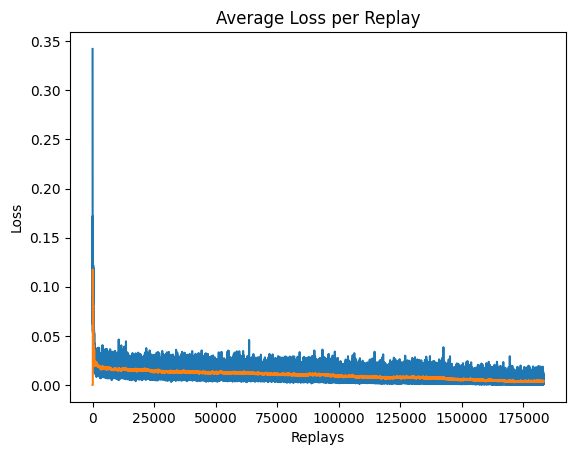

✓ Training metrics saved


In [16]:
# EXPERIMENT 1: Training Against NAIVE Opponent
print("=== EXPERIMENT 1: Training Against NAIVE Opponent ===")

# Load baseline and configure for training
agent, optimizer, criterion = supply_model(
    load_if_exists=True,
    agent_name=BASELINE,
    optimizer_type="ADAM"
)

# Configure epsilon decay with cosine annealing
agent.LOG_DETAILS = False
agent.anneal_epsilon = True
agent.prep_cosine_anneal(0.01, 1.0, NUM_EPISODES // 2)  # 50K episodes

print(f"✓ Agent configured:")
print(f"  - Epsilon: {agent.epsilon:.3f}")
print(f"  - Training episodes: {NUM_EPISODES // 2:,}")
print(f"  - Cosine annealing: {agent.epsilon_min:.3f} to {agent.epsilon_max:.3f}")

# Create environment with proper initialization
environment = TicTacToeGame(DEVICE, None, OPPONENT_LEVEL.NAIVE, start_as_X=True)
print(f"✓ Environment configured against {environment.opponent_level.value} opponent")

# Training against NAIVE opponent
print("\nStarting training against NAIVE opponent...")
start_time = datetime.now()

try:
    metrics_naive = train_agent(
        agent=agent,
        environment=environment,
        num_episodes=NUM_EPISODES // 2,  # 50K episodes
        optimizer=optimizer,
        criterion=criterion,
        device=DEVICE,
        save_path=MODEL_PATH,
        model_name=NAIVE,
        save_every=SAVE_FREQUENCY,
    )
    
    end_time = datetime.now()
    training_duration = end_time - start_time
    
    print(f"\n✓ NAIVE training completed in {training_duration}")
    print(f"  - Final epsilon: {agent.epsilon:.4f}")
    print(f"  - Total wins: {metrics_naive['wins']}")
    print(f"  - Total draws: {metrics_naive['draws']}")
    print(f"  - Total losses: {metrics_naive['losses']}")
    print(f"  - Win rate: {100 * metrics_naive['wins'] / (NUM_EPISODES // 2):.2f}%")
    
    # Plot training progress
    agent.plot_loss_history()
    
    # Save training metrics
    import pickle
    with open(os.path.join(MODEL_PATH, f"{NAIVE}_metrics.pkl"), 'wb') as f:
        pickle.dump(metrics_naive, f)
    print("✓ Training metrics saved")
    
except Exception as e:
    print(f"❌ Training failed: {e}")
    import traceback
    traceback.print_exc()

In [17]:
# EXPERIMENT 2: Training Against OPTIMAL Opponent
print("=== EXPERIMENT 2: Training Against OPTIMAL Opponent ===")

# The agent should already be loaded from previous cell
# Reset epsilon for optimal opponent training
agent.epsilon = 0.1  # Lower exploration for tougher opponent
print(f"✓ Epsilon reset to {agent.epsilon} for OPTIMAL opponent")

# Switch to OPTIMAL opponent
environment.set_opponent_level(OPPONENT_LEVEL.OPTIMAL)
print(f"✓ Environment switched to {environment.opponent_level.value} opponent")

# Reset epsilon decay for second phase
agent.prep_cosine_anneal(0.01, 0.1, NUM_EPISODES // 2)  # Lower exploration range
print("✓ Cosine annealing reconfigured for OPTIMAL training")

print(f"\nStarting training against OPTIMAL opponent...")
start_time = datetime.now()

try:
    metrics_optimal = train_agent(
        agent=agent,
        environment=environment,
        num_episodes=NUM_EPISODES // 2,  # 50K episodes
        optimizer=optimizer,
        criterion=criterion,
        device=DEVICE,
        save_path=MODEL_PATH,
        model_name=OPTIMAL,
        save_every=SAVE_FREQUENCY,
    )
    
    end_time = datetime.now()
    training_duration = end_time - start_time
    
    print(f"\n✓ OPTIMAL training completed in {training_duration}")
    print(f"  - Final epsilon: {agent.epsilon:.4f}")
    print(f"  - Total wins: {metrics_optimal['wins']}")
    print(f"  - Total draws: {metrics_optimal['draws']}")
    print(f"  - Total losses: {metrics_optimal['losses']}")
    print(f"  - Win rate: {100 * metrics_optimal['wins'] / (NUM_EPISODES // 2):.2f}%")
    
    # Save training metrics
    import pickle
    with open(os.path.join(MODEL_PATH, f"{OPTIMAL}_metrics.pkl"), 'wb') as f:
        pickle.dump(metrics_optimal, f)
    print("✓ Training metrics saved")
    
except Exception as e:
    print(f"❌ OPTIMAL training failed: {e}")
    import traceback
    traceback.print_exc()

=== EXPERIMENT 2: Training Against OPTIMAL Opponent ===
✓ Epsilon reset to 0.1 for OPTIMAL opponent
✓ Environment switched to optimal opponent
✓ Cosine annealing reconfigured for OPTIMAL training

Starting training against OPTIMAL opponent...
[0010/50000] Steps: 4 Reward: 0.30, Loss: 0.0035 Epsilon: 0.1000, Role: O Win: 0.00% Draw: 50.00% Loss: 50.00%
[0020/50000] Steps: 3 Reward: -1.00, Loss: 0.0063 Epsilon: 0.1000, Role: O Win: 5.00% Draw: 40.00% Loss: 55.00%
[0030/50000] Steps: 3 Reward: -1.00, Loss: 0.0066 Epsilon: 0.1000, Role: O Win: 6.67% Draw: 40.00% Loss: 53.33%
[0040/50000] Steps: 3 Reward: -1.00, Loss: 0.0059 Epsilon: 0.1000, Role: O Win: 12.50% Draw: 37.50% Loss: 50.00%
[0050/50000] Steps: 4 Reward: 0.30, Loss: 0.0087 Epsilon: 0.1000, Role: O Win: 14.00% Draw: 36.00% Loss: 50.00%
[0060/50000] Steps: 2 Reward: -1.00, Loss: 0.0027 Epsilon: 0.1000, Role: O Win: 15.00% Draw: 31.67% Loss: 53.33%
[0070/50000] Steps: 4 Reward: 0.30, Loss: 0.0037 Epsilon: 0.1000, Role: O Win: 15.71

2025-12-05 17:48:07 - DeepQAgent - INFO - Model saved to '/Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-OPTIMAL-5K.pt'.


[5010/50000] Steps: 4 Reward: 0.30, Loss: 0.0036 Epsilon: 0.0978, Role: O Win: 32.24% Draw: 50.24% Loss: 17.52%
[5020/50000] Steps: 4 Reward: 0.30, Loss: 0.0030 Epsilon: 0.0978, Role: O Win: 32.27% Draw: 50.24% Loss: 17.49%
[5030/50000] Steps: 4 Reward: 0.30, Loss: 0.0022 Epsilon: 0.0978, Role: O Win: 32.27% Draw: 50.26% Loss: 17.48%
[5040/50000] Steps: 3 Reward: -1.00, Loss: 0.0026 Epsilon: 0.0978, Role: O Win: 32.30% Draw: 50.20% Loss: 17.50%
[5050/50000] Steps: 4 Reward: 0.30, Loss: 0.0018 Epsilon: 0.0978, Role: O Win: 32.34% Draw: 50.20% Loss: 17.47%
[5060/50000] Steps: 4 Reward: -1.00, Loss: 0.0033 Epsilon: 0.0977, Role: O Win: 32.29% Draw: 50.22% Loss: 17.49%
[5070/50000] Steps: 4 Reward: 0.30, Loss: 0.0024 Epsilon: 0.0977, Role: O Win: 32.29% Draw: 50.26% Loss: 17.46%
[5080/50000] Steps: 4 Reward: 0.30, Loss: 0.0032 Epsilon: 0.0977, Role: O Win: 32.26% Draw: 50.26% Loss: 17.48%
[5090/50000] Steps: 4 Reward: -1.00, Loss: 0.0024 Epsilon: 0.0977, Role: O Win: 32.28% Draw: 50.26% Lo

2025-12-05 18:27:15 - DeepQAgent - INFO - Model saved to '/Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-OPTIMAL-10K.pt'.


[10010/50000] Steps: 4 Reward: 0.30, Loss: 0.0021 Epsilon: 0.0914, Role: O Win: 34.65% Draw: 50.23% Loss: 15.12%
[10020/50000] Steps: 4 Reward: 0.30, Loss: 0.0018 Epsilon: 0.0914, Role: O Win: 34.66% Draw: 50.21% Loss: 15.13%
[10030/50000] Steps: 4 Reward: 0.30, Loss: 0.0022 Epsilon: 0.0914, Role: O Win: 34.67% Draw: 50.22% Loss: 15.11%
[10040/50000] Steps: 2 Reward: -1.00, Loss: 0.0025 Epsilon: 0.0913, Role: O Win: 34.66% Draw: 50.21% Loss: 15.13%
[10050/50000] Steps: 4 Reward: 0.30, Loss: 0.0022 Epsilon: 0.0913, Role: O Win: 34.66% Draw: 50.20% Loss: 15.14%
[10060/50000] Steps: 4 Reward: 0.30, Loss: 0.0019 Epsilon: 0.0913, Role: O Win: 34.66% Draw: 50.20% Loss: 15.14%
[10070/50000] Steps: 3 Reward: -1.00, Loss: 0.0016 Epsilon: 0.0913, Role: O Win: 34.68% Draw: 50.19% Loss: 15.13%
[10080/50000] Steps: 3 Reward: -1.00, Loss: 0.0025 Epsilon: 0.0913, Role: O Win: 34.69% Draw: 50.17% Loss: 15.14%
[10090/50000] Steps: 4 Reward: 0.30, Loss: 0.0023 Epsilon: 0.0913, Role: O Win: 34.70% Draw: 

2025-12-05 19:06:27 - DeepQAgent - INFO - Model saved to '/Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-OPTIMAL-15K.pt'.


[15010/50000] Steps: 4 Reward: 0.30, Loss: 0.0018 Epsilon: 0.0814, Role: O Win: 35.87% Draw: 50.19% Loss: 13.94%
[15020/50000] Steps: 4 Reward: 0.30, Loss: 0.0021 Epsilon: 0.0814, Role: O Win: 35.88% Draw: 50.19% Loss: 13.93%
[15030/50000] Steps: 4 Reward: 0.30, Loss: 0.0019 Epsilon: 0.0814, Role: O Win: 35.88% Draw: 50.20% Loss: 13.92%
[15040/50000] Steps: 3 Reward: -1.00, Loss: 0.0026 Epsilon: 0.0814, Role: O Win: 35.88% Draw: 50.19% Loss: 13.93%
[15050/50000] Steps: 4 Reward: 0.30, Loss: 0.0013 Epsilon: 0.0813, Role: O Win: 35.89% Draw: 50.19% Loss: 13.93%
[15060/50000] Steps: 4 Reward: 0.30, Loss: 0.0021 Epsilon: 0.0813, Role: O Win: 35.89% Draw: 50.18% Loss: 13.93%
[15070/50000] Steps: 4 Reward: 0.30, Loss: 0.0020 Epsilon: 0.0813, Role: O Win: 35.89% Draw: 50.18% Loss: 13.93%
[15080/50000] Steps: 4 Reward: 0.30, Loss: 0.0019 Epsilon: 0.0813, Role: O Win: 35.90% Draw: 50.19% Loss: 13.92%
[15090/50000] Steps: 4 Reward: 0.30, Loss: 0.0019 Epsilon: 0.0812, Role: O Win: 35.89% Draw: 50

2025-12-05 19:45:40 - DeepQAgent - INFO - Model saved to '/Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-OPTIMAL-20K.pt'.


[20000/50000] Steps: 4 Reward: 0.30, Loss: 0.0016 Epsilon: 0.0689, Role: O Win: 36.56% Draw: 50.43% Loss: 13.01%
[20010/50000] Steps: 4 Reward: 0.30, Loss: 0.0011 Epsilon: 0.0689, Role: O Win: 36.57% Draw: 50.43% Loss: 13.00%
[20020/50000] Steps: 4 Reward: 0.30, Loss: 0.0014 Epsilon: 0.0689, Role: O Win: 36.57% Draw: 50.43% Loss: 13.00%
[20030/50000] Steps: 4 Reward: 0.30, Loss: 0.0017 Epsilon: 0.0688, Role: O Win: 36.56% Draw: 50.44% Loss: 13.00%
[20040/50000] Steps: 4 Reward: 0.30, Loss: 0.0016 Epsilon: 0.0688, Role: O Win: 36.56% Draw: 50.43% Loss: 13.01%
[20050/50000] Steps: 4 Reward: 0.30, Loss: 0.0017 Epsilon: 0.0688, Role: O Win: 36.57% Draw: 50.43% Loss: 13.00%
[20060/50000] Steps: 4 Reward: 0.30, Loss: 0.0016 Epsilon: 0.0687, Role: O Win: 36.58% Draw: 50.43% Loss: 13.00%
[20070/50000] Steps: 3 Reward: -1.00, Loss: 0.0009 Epsilon: 0.0687, Role: O Win: 36.58% Draw: 50.42% Loss: 12.99%
[20080/50000] Steps: 4 Reward: 0.30, Loss: 0.0024 Epsilon: 0.0687, Role: O Win: 36.58% Draw: 50

2025-12-05 20:25:07 - DeepQAgent - INFO - Model saved to '/Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-OPTIMAL-25K.pt'.


[25010/50000] Steps: 3 Reward: -1.00, Loss: 0.0012 Epsilon: 0.0550, Role: O Win: 37.18% Draw: 50.85% Loss: 11.97%
[25020/50000] Steps: 4 Reward: 0.30, Loss: 0.0020 Epsilon: 0.0549, Role: O Win: 37.18% Draw: 50.86% Loss: 11.97%
[25030/50000] Steps: 4 Reward: 0.30, Loss: 0.0021 Epsilon: 0.0549, Role: O Win: 37.18% Draw: 50.86% Loss: 11.96%
[25040/50000] Steps: 4 Reward: 0.30, Loss: 0.0015 Epsilon: 0.0549, Role: O Win: 37.18% Draw: 50.85% Loss: 11.96%
[25050/50000] Steps: 4 Reward: 0.30, Loss: 0.0011 Epsilon: 0.0549, Role: O Win: 37.18% Draw: 50.86% Loss: 11.96%
[25060/50000] Steps: 4 Reward: 0.30, Loss: 0.0019 Epsilon: 0.0548, Role: O Win: 37.18% Draw: 50.86% Loss: 11.96%
[25070/50000] Steps: 4 Reward: 0.30, Loss: 0.0018 Epsilon: 0.0548, Role: O Win: 37.18% Draw: 50.87% Loss: 11.95%
[25080/50000] Steps: 4 Reward: 0.30, Loss: 0.0014 Epsilon: 0.0548, Role: O Win: 37.19% Draw: 50.87% Loss: 11.95%
[25090/50000] Steps: 4 Reward: 0.30, Loss: 0.0037 Epsilon: 0.0548, Role: O Win: 37.19% Draw: 50

2025-12-05 21:04:49 - DeepQAgent - INFO - Model saved to '/Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-OPTIMAL-30K.pt'.


[30010/50000] Steps: 4 Reward: 0.30, Loss: 0.0019 Epsilon: 0.0411, Role: O Win: 37.75% Draw: 51.09% Loss: 11.16%
[30020/50000] Steps: 4 Reward: 0.30, Loss: 0.0015 Epsilon: 0.0410, Role: O Win: 37.75% Draw: 51.10% Loss: 11.15%
[30030/50000] Steps: 4 Reward: 0.30, Loss: 0.0011 Epsilon: 0.0410, Role: O Win: 37.75% Draw: 51.10% Loss: 11.15%
[30040/50000] Steps: 4 Reward: 0.30, Loss: 0.0012 Epsilon: 0.0410, Role: O Win: 37.75% Draw: 51.10% Loss: 11.15%
[30050/50000] Steps: 4 Reward: 0.30, Loss: 0.0020 Epsilon: 0.0410, Role: O Win: 37.75% Draw: 51.10% Loss: 11.15%
[30060/50000] Steps: 4 Reward: 0.30, Loss: 0.0015 Epsilon: 0.0409, Role: O Win: 37.74% Draw: 51.11% Loss: 11.15%
[30070/50000] Steps: 4 Reward: 0.30, Loss: 0.0010 Epsilon: 0.0409, Role: O Win: 37.74% Draw: 51.11% Loss: 11.14%
[30080/50000] Steps: 4 Reward: 0.30, Loss: 0.0019 Epsilon: 0.0409, Role: O Win: 37.74% Draw: 51.12% Loss: 11.14%
[30090/50000] Steps: 4 Reward: 0.30, Loss: 0.0016 Epsilon: 0.0409, Role: O Win: 37.74% Draw: 51.

2025-12-05 21:44:40 - DeepQAgent - INFO - Model saved to '/Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-OPTIMAL-35K.pt'.


[35010/50000] Steps: 4 Reward: 0.30, Loss: 0.0014 Epsilon: 0.0285, Role: O Win: 38.21% Draw: 51.52% Loss: 10.27%
[35020/50000] Steps: 4 Reward: 0.30, Loss: 0.0018 Epsilon: 0.0285, Role: O Win: 38.21% Draw: 51.52% Loss: 10.27%
[35030/50000] Steps: 4 Reward: 0.30, Loss: 0.0010 Epsilon: 0.0285, Role: O Win: 38.21% Draw: 51.52% Loss: 10.26%
[35040/50000] Steps: 4 Reward: 0.30, Loss: 0.0010 Epsilon: 0.0285, Role: O Win: 38.21% Draw: 51.53% Loss: 10.26%
[35050/50000] Steps: 4 Reward: 0.30, Loss: 0.0013 Epsilon: 0.0284, Role: O Win: 38.21% Draw: 51.53% Loss: 10.26%
[35060/50000] Steps: 4 Reward: 0.30, Loss: 0.0014 Epsilon: 0.0284, Role: O Win: 38.21% Draw: 51.53% Loss: 10.26%
[35070/50000] Steps: 4 Reward: 0.30, Loss: 0.0018 Epsilon: 0.0284, Role: O Win: 38.21% Draw: 51.53% Loss: 10.26%
[35080/50000] Steps: 4 Reward: 0.30, Loss: 0.0014 Epsilon: 0.0284, Role: O Win: 38.21% Draw: 51.53% Loss: 10.25%
[35090/50000] Steps: 4 Reward: 0.30, Loss: 0.0013 Epsilon: 0.0283, Role: O Win: 38.22% Draw: 51.

2025-12-05 22:24:12 - DeepQAgent - INFO - Model saved to '/Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-OPTIMAL-40K.pt'.


[40010/50000] Steps: 4 Reward: 0.30, Loss: 0.0013 Epsilon: 0.0186, Role: O Win: 38.66% Draw: 51.97% Loss: 9.37%
[40020/50000] Steps: 4 Reward: 0.30, Loss: 0.0013 Epsilon: 0.0186, Role: O Win: 38.66% Draw: 51.97% Loss: 9.36%
[40030/50000] Steps: 4 Reward: 0.30, Loss: 0.0006 Epsilon: 0.0185, Role: O Win: 38.66% Draw: 51.98% Loss: 9.36%
[40040/50000] Steps: 3 Reward: -1.00, Loss: 0.0009 Epsilon: 0.0185, Role: O Win: 38.67% Draw: 51.97% Loss: 9.36%
[40050/50000] Steps: 4 Reward: 0.30, Loss: 0.0014 Epsilon: 0.0185, Role: O Win: 38.67% Draw: 51.97% Loss: 9.36%
[40060/50000] Steps: 4 Reward: 0.30, Loss: 0.0011 Epsilon: 0.0185, Role: O Win: 38.67% Draw: 51.97% Loss: 9.36%
[40070/50000] Steps: 4 Reward: 0.30, Loss: 0.0013 Epsilon: 0.0185, Role: O Win: 38.67% Draw: 51.97% Loss: 9.36%
[40080/50000] Steps: 4 Reward: 0.30, Loss: 0.0013 Epsilon: 0.0185, Role: O Win: 38.67% Draw: 51.97% Loss: 9.36%
[40090/50000] Steps: 4 Reward: 0.30, Loss: 0.0007 Epsilon: 0.0184, Role: O Win: 38.67% Draw: 51.97% Los

2025-12-05 23:03:40 - DeepQAgent - INFO - Model saved to '/Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-OPTIMAL-45K.pt'.


[45010/50000] Steps: 4 Reward: 0.30, Loss: 0.0011 Epsilon: 0.0122, Role: O Win: 39.00% Draw: 52.37% Loss: 8.63%
[45020/50000] Steps: 3 Reward: -1.00, Loss: 0.0012 Epsilon: 0.0122, Role: O Win: 39.01% Draw: 52.36% Loss: 8.63%
[45030/50000] Steps: 4 Reward: 0.30, Loss: 0.0012 Epsilon: 0.0122, Role: O Win: 39.01% Draw: 52.37% Loss: 8.63%
[45040/50000] Steps: 4 Reward: 0.30, Loss: 0.0006 Epsilon: 0.0122, Role: O Win: 39.01% Draw: 52.36% Loss: 8.63%
[45050/50000] Steps: 4 Reward: 0.30, Loss: 0.0010 Epsilon: 0.0122, Role: O Win: 39.01% Draw: 52.36% Loss: 8.62%
[45060/50000] Steps: 4 Reward: 0.30, Loss: 0.0013 Epsilon: 0.0122, Role: O Win: 39.01% Draw: 52.36% Loss: 8.62%
[45070/50000] Steps: 4 Reward: 0.30, Loss: 0.0016 Epsilon: 0.0121, Role: O Win: 39.02% Draw: 52.36% Loss: 8.62%
[45080/50000] Steps: 4 Reward: 0.30, Loss: 0.0011 Epsilon: 0.0121, Role: O Win: 39.02% Draw: 52.36% Loss: 8.62%
[45090/50000] Steps: 4 Reward: 0.30, Loss: 0.0011 Epsilon: 0.0121, Role: O Win: 39.02% Draw: 52.36% Los

2025-12-05 23:53:46 - DeepQAgent - INFO - Model saved to '/Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-OPTIMAL-50K.pt'.



✓ OPTIMAL training completed in 6:43:35.211296
  - Final epsilon: 0.0100
  - Total wins: 19665
  - Total draws: 26357
  - Total losses: 3978
  - Win rate: 39.33%
✓ Training metrics saved


2025-12-05 23:53:46 - DeepQAgent - INFO - Model saved to '/Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/FINAL_MODEL.pt'.


=== Saving Final Model and Results ===
✓ Final model saved to: /Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/FINAL_MODEL.pt

Generating loss history plot...


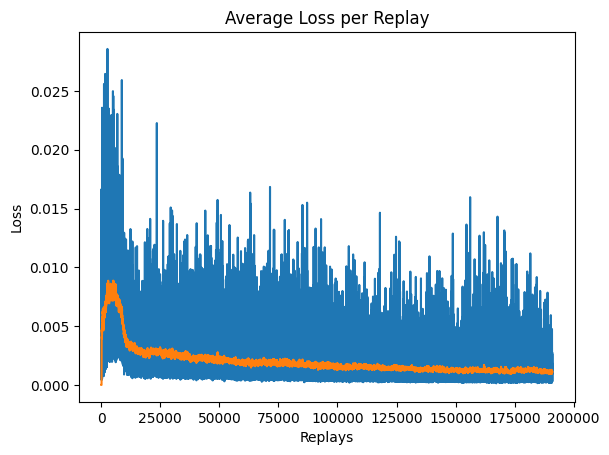

2025-12-05 23:53:46 - DeepQAgent - INFO - Model loaded from '/Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/FINAL_MODEL.pt'.



=== Final Model Validation ===

=== Validating FINAL_MODEL Performance ===
Creating agent with configuration:
  - Device: cpu
  - Optimizer: ADAM
  - Load existing: True
Loading model from: /Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/FINAL_MODEL.pt
✓ Model loaded successfully
✓ ADAM optimizer created

Testing against NAIVE opponent...


100%|██████████| 1000/1000 [00:01<00:00, 728.47it/s]



Results as X (500 games):
Win rate:  91.40% (457/500)
Draw rate: 4.60% (23/500)
Loss rate: 4.00% (20/500)
Avg reward: 0.93


Results as O (500 games):
Win rate:  59.40% (297/500)
Draw rate: 30.20% (151/500)
Loss rate: 10.40% (52/500)
Avg reward: 0.59


Overall Statistics:
Total games: 1000
Overall win rate: 75.40%
Average game length: 3.7 moves
Game length std: 0.6

Testing against OPTIMAL opponent...


100%|██████████| 100/100 [00:37<00:00,  2.69it/s]


Results as X (50 games):
Win rate:  86.00% (43/50)
Draw rate: 14.00% (7/50)
Loss rate: 0.00% (0/50)
Avg reward: 0.90


Results as O (50 games):
Win rate:  0.00% (0/50)
Draw rate: 100.00% (50/50)
Loss rate: 0.00% (0/50)
Avg reward: 0.00


Overall Statistics:
Total games: 100
Overall win rate: 43.00%
Average game length: 3.8 moves
Game length std: 0.6
✓ Final validation completed successfully
✓ Validation results saved


In [18]:
# Save Final Model and Visualize Training
print("=== Saving Final Model and Results ===")

# Save the final trained model
final_model_path = agent.save_model(MODEL_PATH, "FINAL_MODEL")
print(f"✓ Final model saved to: {final_model_path}")

# Plot final loss history
print("\nGenerating loss history plot...")
agent.plot_loss_history()

# Comprehensive validation of final model
print("\n=== Final Model Validation ===")
final_results = validate_agent_performance("FINAL_MODEL", num_episodes=VALIDATION_EPISODES)

if final_results:
    print("✓ Final validation completed successfully")
    
    # Save validation results
    import pickle
    with open(os.path.join(MODEL_PATH, "FINAL_MODEL_validation.pkl"), 'wb') as f:
        pickle.dump(final_results, f)
    print("✓ Validation results saved")
else:
    print("❌ Final validation failed")

In [19]:
# EVALUATION: Progressive Model Performance Analysis
print("=== Progressive Model Performance Analysis ===")

# Models to test (based on training checkpoints)
checkpoint_models = [
    f"{NAIVE}-5K", f"{NAIVE}-10K", f"{NAIVE}-15K", f"{NAIVE}-20K", 
    f"{NAIVE}-25K", f"{NAIVE}-30K", f"{NAIVE}-35K", f"{NAIVE}-40K", 
    f"{NAIVE}-45K", f"{NAIVE}-50K"
]

# Test each checkpoint
progressive_results = {}

for model_name in checkpoint_models:
    print(f"\n--- Testing {model_name} ---")
    
    try:
        # Quick validation (fewer episodes for speed)
        results = validate_agent_performance(model_name, num_episodes=200)
        
        if results:
            progressive_results[model_name] = results
            
            # Extract key metrics
            naive_wins = results['naive']['X']['W'] + results['naive']['O']['W']
            naive_total = 200  # We tested with 200 episodes
            optimal_wins = results['optimal']['X']['W'] + results['optimal']['O']['W']
            optimal_total = 20  # 200//10 = 20 episodes against optimal
            
            print(f"  vs NAIVE: {100*naive_wins/naive_total:.1f}% win rate")
            print(f"  vs OPTIMAL: {100*optimal_wins/optimal_total:.1f}% win rate")
        else:
            print(f"  ❌ Model {model_name} not found or failed to load")
            
    except Exception as e:
        print(f"  ❌ Error testing {model_name}: {e}")

# Save progressive results
if progressive_results:
    import pickle
    with open(os.path.join(MODEL_PATH, "progressive_results.pkl"), 'wb') as f:
        pickle.dump(progressive_results, f)
    print(f"\n✓ Progressive results saved for {len(progressive_results)} models")
else:
    print("\n❌ No progressive results to save")

2025-12-05 23:54:24 - DeepQAgent - INFO - Model loaded from '/Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-NAIVE-5K.pt'.


=== Progressive Model Performance Analysis ===

--- Testing TicTacToe-v2-NAIVE-5K ---

=== Validating TicTacToe-v2-NAIVE-5K Performance ===
Creating agent with configuration:
  - Device: cpu
  - Optimizer: ADAM
  - Load existing: True
Loading model from: /Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-NAIVE-5K.pt
✓ Model loaded successfully
✓ ADAM optimizer created

Testing against NAIVE opponent...


100%|██████████| 200/200 [00:00<00:00, 789.26it/s]



Results as X (100 games):
Win rate:  96.00% (96/100)
Draw rate: 3.00% (3/100)
Loss rate: 1.00% (1/100)
Avg reward: 0.97


Results as O (100 games):
Win rate:  70.00% (70/100)
Draw rate: 11.00% (11/100)
Loss rate: 19.00% (19/100)
Avg reward: 0.70


Overall Statistics:
Total games: 200
Overall win rate: 83.00%
Average game length: 3.4 moves
Game length std: 0.7

Testing against OPTIMAL opponent...


100%|██████████| 20/20 [00:06<00:00,  2.91it/s]
2025-12-05 23:54:31 - DeepQAgent - INFO - Model loaded from '/Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-NAIVE-10K.pt'.



Results as X (10 games):
Win rate:  50.00% (5/10)
Draw rate: 50.00% (5/10)
Loss rate: 0.00% (0/10)
Avg reward: 0.65


Results as O (10 games):
Win rate:  0.00% (0/10)
Draw rate: 0.00% (0/10)
Loss rate: 100.00% (10/10)
Avg reward: 0.00


Overall Statistics:
Total games: 20
Overall win rate: 25.00%
Average game length: 3.5 moves
Game length std: 1.0
  vs NAIVE: 83.0% win rate
  vs OPTIMAL: 25.0% win rate

--- Testing TicTacToe-v2-NAIVE-10K ---

=== Validating TicTacToe-v2-NAIVE-10K Performance ===
Creating agent with configuration:
  - Device: cpu
  - Optimizer: ADAM
  - Load existing: True
Loading model from: /Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-NAIVE-10K.pt
✓ Model loaded successfully
✓ ADAM optimizer created

Testing against NAIVE opponent...


100%|██████████| 200/200 [00:00<00:00, 802.59it/s]



Results as X (100 games):
Win rate:  97.00% (97/100)
Draw rate: 3.00% (3/100)
Loss rate: 0.00% (0/100)
Avg reward: 0.98


Results as O (100 games):
Win rate:  80.00% (80/100)
Draw rate: 6.00% (6/100)
Loss rate: 14.00% (14/100)
Avg reward: 0.80


Overall Statistics:
Total games: 200
Overall win rate: 88.50%
Average game length: 3.4 moves
Game length std: 0.6

Testing against OPTIMAL opponent...


100%|██████████| 20/20 [00:07<00:00,  2.76it/s]
2025-12-05 23:54:39 - DeepQAgent - INFO - Model loaded from '/Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-NAIVE-15K.pt'.



Results as X (10 games):
Win rate:  50.00% (5/10)
Draw rate: 40.00% (4/10)
Loss rate: 10.00% (1/10)
Avg reward: 0.62


Results as O (10 games):
Win rate:  0.00% (0/10)
Draw rate: 20.00% (2/10)
Loss rate: 80.00% (8/10)
Avg reward: 0.00


Overall Statistics:
Total games: 20
Overall win rate: 25.00%
Average game length: 3.3 moves
Game length std: 1.1
  vs NAIVE: 88.5% win rate
  vs OPTIMAL: 25.0% win rate

--- Testing TicTacToe-v2-NAIVE-15K ---

=== Validating TicTacToe-v2-NAIVE-15K Performance ===
Creating agent with configuration:
  - Device: cpu
  - Optimizer: ADAM
  - Load existing: True
Loading model from: /Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-NAIVE-15K.pt
✓ Model loaded successfully
✓ ADAM optimizer created

Testing against NAIVE opponent...


100%|██████████| 200/200 [00:00<00:00, 811.77it/s]



Results as X (100 games):
Win rate:  95.00% (95/100)
Draw rate: 2.00% (2/100)
Loss rate: 3.00% (3/100)
Avg reward: 0.96


Results as O (100 games):
Win rate:  79.00% (79/100)
Draw rate: 8.00% (8/100)
Loss rate: 13.00% (13/100)
Avg reward: 0.79


Overall Statistics:
Total games: 200
Overall win rate: 87.00%
Average game length: 3.4 moves
Game length std: 0.6

Testing against OPTIMAL opponent...


100%|██████████| 20/20 [00:07<00:00,  2.69it/s]
2025-12-05 23:54:47 - DeepQAgent - INFO - Model loaded from '/Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-NAIVE-20K.pt'.



Results as X (10 games):
Win rate:  20.00% (2/10)
Draw rate: 40.00% (4/10)
Loss rate: 40.00% (4/10)
Avg reward: 0.32


Results as O (10 games):
Win rate:  0.00% (0/10)
Draw rate: 30.00% (3/10)
Loss rate: 70.00% (7/10)
Avg reward: 0.00


Overall Statistics:
Total games: 20
Overall win rate: 10.00%
Average game length: 3.7 moves
Game length std: 0.8
  vs NAIVE: 87.0% win rate
  vs OPTIMAL: 10.0% win rate

--- Testing TicTacToe-v2-NAIVE-20K ---

=== Validating TicTacToe-v2-NAIVE-20K Performance ===
Creating agent with configuration:
  - Device: cpu
  - Optimizer: ADAM
  - Load existing: True
Loading model from: /Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-NAIVE-20K.pt
✓ Model loaded successfully
✓ ADAM optimizer created

Testing against NAIVE opponent...


100%|██████████| 200/200 [00:00<00:00, 804.09it/s]



Results as X (100 games):
Win rate:  94.00% (94/100)
Draw rate: 1.00% (1/100)
Loss rate: 5.00% (5/100)
Avg reward: 0.94


Results as O (100 games):
Win rate:  89.00% (89/100)
Draw rate: 7.00% (7/100)
Loss rate: 4.00% (4/100)
Avg reward: 0.89


Overall Statistics:
Total games: 200
Overall win rate: 91.50%
Average game length: 3.4 moves
Game length std: 0.6

Testing against OPTIMAL opponent...


100%|██████████| 20/20 [00:07<00:00,  2.63it/s]
2025-12-05 23:54:55 - DeepQAgent - INFO - Model loaded from '/Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-NAIVE-25K.pt'.



Results as X (10 games):
Win rate:  20.00% (2/10)
Draw rate: 40.00% (4/10)
Loss rate: 40.00% (4/10)
Avg reward: 0.32


Results as O (10 games):
Win rate:  0.00% (0/10)
Draw rate: 60.00% (6/10)
Loss rate: 40.00% (4/10)
Avg reward: 0.00


Overall Statistics:
Total games: 20
Overall win rate: 10.00%
Average game length: 4.0 moves
Game length std: 0.6
  vs NAIVE: 91.5% win rate
  vs OPTIMAL: 10.0% win rate

--- Testing TicTacToe-v2-NAIVE-25K ---

=== Validating TicTacToe-v2-NAIVE-25K Performance ===
Creating agent with configuration:
  - Device: cpu
  - Optimizer: ADAM
  - Load existing: True
Loading model from: /Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-NAIVE-25K.pt
✓ Model loaded successfully
✓ ADAM optimizer created

Testing against NAIVE opponent...


100%|██████████| 200/200 [00:00<00:00, 775.38it/s]



Results as X (100 games):
Win rate:  93.00% (93/100)
Draw rate: 1.00% (1/100)
Loss rate: 6.00% (6/100)
Avg reward: 0.93


Results as O (100 games):
Win rate:  82.00% (82/100)
Draw rate: 9.00% (9/100)
Loss rate: 9.00% (9/100)
Avg reward: 0.82


Overall Statistics:
Total games: 200
Overall win rate: 87.50%
Average game length: 3.4 moves
Game length std: 0.6

Testing against OPTIMAL opponent...


100%|██████████| 20/20 [00:06<00:00,  2.93it/s]
2025-12-05 23:55:02 - DeepQAgent - INFO - Model loaded from '/Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-NAIVE-30K.pt'.



Results as X (10 games):
Win rate:  70.00% (7/10)
Draw rate: 10.00% (1/10)
Loss rate: 20.00% (2/10)
Avg reward: 0.73


Results as O (10 games):
Win rate:  0.00% (0/10)
Draw rate: 30.00% (3/10)
Loss rate: 70.00% (7/10)
Avg reward: 0.00


Overall Statistics:
Total games: 20
Overall win rate: 35.00%
Average game length: 3.3 moves
Game length std: 0.8
  vs NAIVE: 87.5% win rate
  vs OPTIMAL: 35.0% win rate

--- Testing TicTacToe-v2-NAIVE-30K ---

=== Validating TicTacToe-v2-NAIVE-30K Performance ===
Creating agent with configuration:
  - Device: cpu
  - Optimizer: ADAM
  - Load existing: True
Loading model from: /Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-NAIVE-30K.pt
✓ Model loaded successfully
✓ ADAM optimizer created

Testing against NAIVE opponent...


100%|██████████| 200/200 [00:00<00:00, 763.94it/s]



Results as X (100 games):
Win rate:  94.00% (94/100)
Draw rate: 2.00% (2/100)
Loss rate: 4.00% (4/100)
Avg reward: 0.95


Results as O (100 games):
Win rate:  86.00% (86/100)
Draw rate: 7.00% (7/100)
Loss rate: 7.00% (7/100)
Avg reward: 0.86


Overall Statistics:
Total games: 200
Overall win rate: 90.00%
Average game length: 3.5 moves
Game length std: 0.6

Testing against OPTIMAL opponent...


100%|██████████| 20/20 [00:07<00:00,  2.67it/s]
2025-12-05 23:55:09 - DeepQAgent - INFO - Model loaded from '/Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-NAIVE-35K.pt'.



Results as X (10 games):
Win rate:  40.00% (4/10)
Draw rate: 50.00% (5/10)
Loss rate: 10.00% (1/10)
Avg reward: 0.55


Results as O (10 games):
Win rate:  0.00% (0/10)
Draw rate: 60.00% (6/10)
Loss rate: 40.00% (4/10)
Avg reward: 0.00


Overall Statistics:
Total games: 20
Overall win rate: 20.00%
Average game length: 4.0 moves
Game length std: 0.8
  vs NAIVE: 90.0% win rate
  vs OPTIMAL: 20.0% win rate

--- Testing TicTacToe-v2-NAIVE-35K ---

=== Validating TicTacToe-v2-NAIVE-35K Performance ===
Creating agent with configuration:
  - Device: cpu
  - Optimizer: ADAM
  - Load existing: True
Loading model from: /Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-NAIVE-35K.pt
✓ Model loaded successfully
✓ ADAM optimizer created

Testing against NAIVE opponent...


100%|██████████| 200/200 [00:00<00:00, 753.26it/s]



Results as X (100 games):
Win rate:  97.00% (97/100)
Draw rate: 1.00% (1/100)
Loss rate: 2.00% (2/100)
Avg reward: 0.97


Results as O (100 games):
Win rate:  83.00% (83/100)
Draw rate: 4.00% (4/100)
Loss rate: 13.00% (13/100)
Avg reward: 0.83


Overall Statistics:
Total games: 200
Overall win rate: 90.00%
Average game length: 3.4 moves
Game length std: 0.6

Testing against OPTIMAL opponent...


100%|██████████| 20/20 [00:06<00:00,  2.92it/s]
2025-12-05 23:55:16 - DeepQAgent - INFO - Model loaded from '/Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-NAIVE-40K.pt'.



Results as X (10 games):
Win rate:  60.00% (6/10)
Draw rate: 40.00% (4/10)
Loss rate: 0.00% (0/10)
Avg reward: 0.72


Results as O (10 games):
Win rate:  0.00% (0/10)
Draw rate: 0.00% (0/10)
Loss rate: 100.00% (10/10)
Avg reward: 0.00


Overall Statistics:
Total games: 20
Overall win rate: 30.00%
Average game length: 3.4 moves
Game length std: 1.0
  vs NAIVE: 90.0% win rate
  vs OPTIMAL: 30.0% win rate

--- Testing TicTacToe-v2-NAIVE-40K ---

=== Validating TicTacToe-v2-NAIVE-40K Performance ===
Creating agent with configuration:
  - Device: cpu
  - Optimizer: ADAM
  - Load existing: True
Loading model from: /Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-NAIVE-40K.pt
✓ Model loaded successfully
✓ ADAM optimizer created

Testing against NAIVE opponent...


100%|██████████| 200/200 [00:00<00:00, 805.62it/s]



Results as X (100 games):
Win rate:  94.00% (94/100)
Draw rate: 4.00% (4/100)
Loss rate: 2.00% (2/100)
Avg reward: 0.95


Results as O (100 games):
Win rate:  93.00% (93/100)
Draw rate: 4.00% (4/100)
Loss rate: 3.00% (3/100)
Avg reward: 0.93


Overall Statistics:
Total games: 200
Overall win rate: 93.50%
Average game length: 3.3 moves
Game length std: 0.5

Testing against OPTIMAL opponent...


100%|██████████| 20/20 [00:07<00:00,  2.54it/s]
2025-12-05 23:55:25 - DeepQAgent - INFO - Model loaded from '/Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-NAIVE-45K.pt'.



Results as X (10 games):
Win rate:  50.00% (5/10)
Draw rate: 20.00% (2/10)
Loss rate: 30.00% (3/10)
Avg reward: 0.56


Results as O (10 games):
Win rate:  0.00% (0/10)
Draw rate: 0.00% (0/10)
Loss rate: 100.00% (10/10)
Avg reward: 0.00


Overall Statistics:
Total games: 20
Overall win rate: 25.00%
Average game length: 3.3 moves
Game length std: 0.8
  vs NAIVE: 93.5% win rate
  vs OPTIMAL: 25.0% win rate

--- Testing TicTacToe-v2-NAIVE-45K ---

=== Validating TicTacToe-v2-NAIVE-45K Performance ===
Creating agent with configuration:
  - Device: cpu
  - Optimizer: ADAM
  - Load existing: True
Loading model from: /Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-NAIVE-45K.pt
✓ Model loaded successfully
✓ ADAM optimizer created

Testing against NAIVE opponent...


100%|██████████| 200/200 [00:00<00:00, 727.55it/s]



Results as X (100 games):
Win rate:  92.00% (92/100)
Draw rate: 5.00% (5/100)
Loss rate: 3.00% (3/100)
Avg reward: 0.94


Results as O (100 games):
Win rate:  81.00% (81/100)
Draw rate: 12.00% (12/100)
Loss rate: 7.00% (7/100)
Avg reward: 0.81


Overall Statistics:
Total games: 200
Overall win rate: 86.50%
Average game length: 3.4 moves
Game length std: 0.6

Testing against OPTIMAL opponent...


100%|██████████| 20/20 [00:07<00:00,  2.65it/s]
2025-12-05 23:55:32 - DeepQAgent - INFO - Model loaded from '/Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-NAIVE-50K.pt'.



Results as X (10 games):
Win rate:  50.00% (5/10)
Draw rate: 50.00% (5/10)
Loss rate: 0.00% (0/10)
Avg reward: 0.65


Results as O (10 games):
Win rate:  0.00% (0/10)
Draw rate: 100.00% (10/10)
Loss rate: 0.00% (0/10)
Avg reward: 0.00


Overall Statistics:
Total games: 20
Overall win rate: 25.00%
Average game length: 4.0 moves
Game length std: 0.7
  vs NAIVE: 86.5% win rate
  vs OPTIMAL: 25.0% win rate

--- Testing TicTacToe-v2-NAIVE-50K ---

=== Validating TicTacToe-v2-NAIVE-50K Performance ===
Creating agent with configuration:
  - Device: cpu
  - Optimizer: ADAM
  - Load existing: True
Loading model from: /Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-NAIVE-50K.pt
✓ Model loaded successfully
✓ ADAM optimizer created

Testing against NAIVE opponent...


100%|██████████| 200/200 [00:00<00:00, 792.22it/s]



Results as X (100 games):
Win rate:  100.00% (100/100)
Draw rate: 0.00% (0/100)
Loss rate: 0.00% (0/100)
Avg reward: 1.00


Results as O (100 games):
Win rate:  87.00% (87/100)
Draw rate: 11.00% (11/100)
Loss rate: 2.00% (2/100)
Avg reward: 0.87


Overall Statistics:
Total games: 200
Overall win rate: 93.50%
Average game length: 3.4 moves
Game length std: 0.5

Testing against OPTIMAL opponent...


100%|██████████| 20/20 [00:07<00:00,  2.65it/s]


Results as X (10 games):
Win rate:  60.00% (6/10)
Draw rate: 40.00% (4/10)
Loss rate: 0.00% (0/10)
Avg reward: 0.72


Results as O (10 games):
Win rate:  0.00% (0/10)
Draw rate: 20.00% (2/10)
Loss rate: 80.00% (8/10)
Avg reward: 0.00


Overall Statistics:
Total games: 20
Overall win rate: 30.00%
Average game length: 3.5 moves
Game length std: 0.8
  vs NAIVE: 93.5% win rate
  vs OPTIMAL: 30.0% win rate

✓ Progressive results saved for 10 models


In [20]:
# EVALUATION: OPTIMAL Phase Checkpoints
print("=== OPTIMAL Phase Checkpoint Analysis ===")

# Test OPTIMAL training checkpoints
optimal_checkpoint_models = [
    f"{OPTIMAL}-5K", f"{OPTIMAL}-10K", f"{OPTIMAL}-15K", f"{OPTIMAL}-20K", 
    f"{OPTIMAL}-25K", f"{OPTIMAL}-30K", f"{OPTIMAL}-35K", f"{OPTIMAL}-40K", 
    f"{OPTIMAL}-45K", f"{OPTIMAL}-50K"
]

optimal_results = {}

for model_name in optimal_checkpoint_models:
    print(f"\n--- Testing {model_name} ---")
    
    try:
        results = validate_agent_performance(model_name, num_episodes=200)
        
        if results:
            optimal_results[model_name] = results
            
            # Extract key metrics
            naive_wins = results['naive']['X']['W'] + results['naive']['O']['W']
            naive_total = 200
            optimal_wins = results['optimal']['X']['W'] + results['optimal']['O']['W']
            optimal_total = 20
            
            print(f"  vs NAIVE: {100*naive_wins/naive_total:.1f}% win rate")
            print(f"  vs OPTIMAL: {100*optimal_wins/optimal_total:.1f}% win rate")
        else:
            print(f"  ❌ Model {model_name} not found")
            
    except Exception as e:
        print(f"  ❌ Error testing {model_name}: {e}")

# Save optimal results
if optimal_results:
    import pickle
    with open(os.path.join(MODEL_PATH, "optimal_results.pkl"), 'wb') as f:
        pickle.dump(optimal_results, f)
    print(f"\n✓ OPTIMAL results saved for {len(optimal_results)} models")
else:
    print("\n❌ No OPTIMAL results to save")

2025-12-05 23:55:40 - DeepQAgent - INFO - Model loaded from '/Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-OPTIMAL-5K.pt'.


=== OPTIMAL Phase Checkpoint Analysis ===

--- Testing TicTacToe-v2-OPTIMAL-5K ---

=== Validating TicTacToe-v2-OPTIMAL-5K Performance ===
Creating agent with configuration:
  - Device: cpu
  - Optimizer: ADAM
  - Load existing: True
Loading model from: /Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-OPTIMAL-5K.pt
✓ Model loaded successfully
✓ ADAM optimizer created

Testing against NAIVE opponent...


100%|██████████| 200/200 [00:00<00:00, 695.21it/s]



Results as X (100 games):
Win rate:  94.00% (94/100)
Draw rate: 3.00% (3/100)
Loss rate: 3.00% (3/100)
Avg reward: 0.95


Results as O (100 games):
Win rate:  75.00% (75/100)
Draw rate: 18.00% (18/100)
Loss rate: 7.00% (7/100)
Avg reward: 0.75


Overall Statistics:
Total games: 200
Overall win rate: 84.50%
Average game length: 3.6 moves
Game length std: 0.5

Testing against OPTIMAL opponent...


100%|██████████| 20/20 [00:07<00:00,  2.72it/s]
2025-12-05 23:55:48 - DeepQAgent - INFO - Model loaded from '/Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-OPTIMAL-10K.pt'.



Results as X (10 games):
Win rate:  80.00% (8/10)
Draw rate: 20.00% (2/10)
Loss rate: 0.00% (0/10)
Avg reward: 0.86


Results as O (10 games):
Win rate:  0.00% (0/10)
Draw rate: 100.00% (10/10)
Loss rate: 0.00% (0/10)
Avg reward: 0.00


Overall Statistics:
Total games: 20
Overall win rate: 40.00%
Average game length: 3.9 moves
Game length std: 0.5
  vs NAIVE: 84.5% win rate
  vs OPTIMAL: 40.0% win rate

--- Testing TicTacToe-v2-OPTIMAL-10K ---

=== Validating TicTacToe-v2-OPTIMAL-10K Performance ===
Creating agent with configuration:
  - Device: cpu
  - Optimizer: ADAM
  - Load existing: True
Loading model from: /Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-OPTIMAL-10K.pt
✓ Model loaded successfully
✓ ADAM optimizer created

Testing against NAIVE opponent...


100%|██████████| 200/200 [00:00<00:00, 689.59it/s]



Results as X (100 games):
Win rate:  99.00% (99/100)
Draw rate: 1.00% (1/100)
Loss rate: 0.00% (0/100)
Avg reward: 0.99


Results as O (100 games):
Win rate:  62.00% (62/100)
Draw rate: 28.00% (28/100)
Loss rate: 10.00% (10/100)
Avg reward: 0.62


Overall Statistics:
Total games: 200
Overall win rate: 80.50%
Average game length: 3.6 moves
Game length std: 0.6

Testing against OPTIMAL opponent...


100%|██████████| 20/20 [00:08<00:00,  2.33it/s]
2025-12-05 23:55:57 - DeepQAgent - INFO - Model loaded from '/Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-OPTIMAL-15K.pt'.



Results as X (10 games):
Win rate:  90.00% (9/10)
Draw rate: 10.00% (1/10)
Loss rate: 0.00% (0/10)
Avg reward: 0.93


Results as O (10 games):
Win rate:  0.00% (0/10)
Draw rate: 100.00% (10/10)
Loss rate: 0.00% (0/10)
Avg reward: 0.00


Overall Statistics:
Total games: 20
Overall win rate: 45.00%
Average game length: 3.9 moves
Game length std: 0.5
  vs NAIVE: 80.5% win rate
  vs OPTIMAL: 45.0% win rate

--- Testing TicTacToe-v2-OPTIMAL-15K ---

=== Validating TicTacToe-v2-OPTIMAL-15K Performance ===
Creating agent with configuration:
  - Device: cpu
  - Optimizer: ADAM
  - Load existing: True
Loading model from: /Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-OPTIMAL-15K.pt
✓ Model loaded successfully
✓ ADAM optimizer created

Testing against NAIVE opponent...


100%|██████████| 200/200 [00:00<00:00, 672.94it/s]



Results as X (100 games):
Win rate:  86.00% (86/100)
Draw rate: 9.00% (9/100)
Loss rate: 5.00% (5/100)
Avg reward: 0.89


Results as O (100 games):
Win rate:  65.00% (65/100)
Draw rate: 23.00% (23/100)
Loss rate: 12.00% (12/100)
Avg reward: 0.65


Overall Statistics:
Total games: 200
Overall win rate: 75.50%
Average game length: 3.7 moves
Game length std: 0.6

Testing against OPTIMAL opponent...


100%|██████████| 20/20 [00:07<00:00,  2.58it/s]
2025-12-05 23:56:05 - DeepQAgent - INFO - Model loaded from '/Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-OPTIMAL-20K.pt'.



Results as X (10 games):
Win rate:  80.00% (8/10)
Draw rate: 20.00% (2/10)
Loss rate: 0.00% (0/10)
Avg reward: 0.86


Results as O (10 games):
Win rate:  0.00% (0/10)
Draw rate: 100.00% (10/10)
Loss rate: 0.00% (0/10)
Avg reward: 0.00


Overall Statistics:
Total games: 20
Overall win rate: 40.00%
Average game length: 4.0 moves
Game length std: 0.5
  vs NAIVE: 75.5% win rate
  vs OPTIMAL: 40.0% win rate

--- Testing TicTacToe-v2-OPTIMAL-20K ---

=== Validating TicTacToe-v2-OPTIMAL-20K Performance ===
Creating agent with configuration:
  - Device: cpu
  - Optimizer: ADAM
  - Load existing: True
Loading model from: /Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-OPTIMAL-20K.pt
✓ Model loaded successfully
✓ ADAM optimizer created

Testing against NAIVE opponent...


100%|██████████| 200/200 [00:00<00:00, 710.80it/s]



Results as X (100 games):
Win rate:  97.00% (97/100)
Draw rate: 2.00% (2/100)
Loss rate: 1.00% (1/100)
Avg reward: 0.98


Results as O (100 games):
Win rate:  62.00% (62/100)
Draw rate: 29.00% (29/100)
Loss rate: 9.00% (9/100)
Avg reward: 0.62


Overall Statistics:
Total games: 200
Overall win rate: 79.50%
Average game length: 3.7 moves
Game length std: 0.6

Testing against OPTIMAL opponent...


100%|██████████| 20/20 [00:07<00:00,  2.55it/s]
2025-12-05 23:56:13 - DeepQAgent - INFO - Model loaded from '/Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-OPTIMAL-25K.pt'.



Results as X (10 games):
Win rate:  80.00% (8/10)
Draw rate: 20.00% (2/10)
Loss rate: 0.00% (0/10)
Avg reward: 0.86


Results as O (10 games):
Win rate:  0.00% (0/10)
Draw rate: 100.00% (10/10)
Loss rate: 0.00% (0/10)
Avg reward: 0.00


Overall Statistics:
Total games: 20
Overall win rate: 40.00%
Average game length: 4.0 moves
Game length std: 0.5
  vs NAIVE: 79.5% win rate
  vs OPTIMAL: 40.0% win rate

--- Testing TicTacToe-v2-OPTIMAL-25K ---

=== Validating TicTacToe-v2-OPTIMAL-25K Performance ===
Creating agent with configuration:
  - Device: cpu
  - Optimizer: ADAM
  - Load existing: True
Loading model from: /Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-OPTIMAL-25K.pt
✓ Model loaded successfully
✓ ADAM optimizer created

Testing against NAIVE opponent...


100%|██████████| 200/200 [00:00<00:00, 717.53it/s]



Results as X (100 games):
Win rate:  97.00% (97/100)
Draw rate: 3.00% (3/100)
Loss rate: 0.00% (0/100)
Avg reward: 0.98


Results as O (100 games):
Win rate:  61.00% (61/100)
Draw rate: 27.00% (27/100)
Loss rate: 12.00% (12/100)
Avg reward: 0.61


Overall Statistics:
Total games: 200
Overall win rate: 79.00%
Average game length: 3.6 moves
Game length std: 0.5

Testing against OPTIMAL opponent...


100%|██████████| 20/20 [00:07<00:00,  2.54it/s]
2025-12-05 23:56:21 - DeepQAgent - INFO - Model loaded from '/Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-OPTIMAL-30K.pt'.



Results as X (10 games):
Win rate:  80.00% (8/10)
Draw rate: 20.00% (2/10)
Loss rate: 0.00% (0/10)
Avg reward: 0.86


Results as O (10 games):
Win rate:  0.00% (0/10)
Draw rate: 100.00% (10/10)
Loss rate: 0.00% (0/10)
Avg reward: 0.00


Overall Statistics:
Total games: 20
Overall win rate: 40.00%
Average game length: 4.2 moves
Game length std: 0.5
  vs NAIVE: 79.0% win rate
  vs OPTIMAL: 40.0% win rate

--- Testing TicTacToe-v2-OPTIMAL-30K ---

=== Validating TicTacToe-v2-OPTIMAL-30K Performance ===
Creating agent with configuration:
  - Device: cpu
  - Optimizer: ADAM
  - Load existing: True
Loading model from: /Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-OPTIMAL-30K.pt
✓ Model loaded successfully
✓ ADAM optimizer created

Testing against NAIVE opponent...


100%|██████████| 200/200 [00:00<00:00, 711.65it/s]



Results as X (100 games):
Win rate:  95.00% (95/100)
Draw rate: 5.00% (5/100)
Loss rate: 0.00% (0/100)
Avg reward: 0.96


Results as O (100 games):
Win rate:  66.00% (66/100)
Draw rate: 23.00% (23/100)
Loss rate: 11.00% (11/100)
Avg reward: 0.66


Overall Statistics:
Total games: 200
Overall win rate: 80.50%
Average game length: 3.5 moves
Game length std: 0.6

Testing against OPTIMAL opponent...


100%|██████████| 20/20 [00:07<00:00,  2.62it/s]
2025-12-05 23:56:29 - DeepQAgent - INFO - Model loaded from '/Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-OPTIMAL-35K.pt'.



Results as X (10 games):
Win rate:  70.00% (7/10)
Draw rate: 30.00% (3/10)
Loss rate: 0.00% (0/10)
Avg reward: 0.79


Results as O (10 games):
Win rate:  0.00% (0/10)
Draw rate: 100.00% (10/10)
Loss rate: 0.00% (0/10)
Avg reward: 0.00


Overall Statistics:
Total games: 20
Overall win rate: 35.00%
Average game length: 3.9 moves
Game length std: 0.6
  vs NAIVE: 80.5% win rate
  vs OPTIMAL: 35.0% win rate

--- Testing TicTacToe-v2-OPTIMAL-35K ---

=== Validating TicTacToe-v2-OPTIMAL-35K Performance ===
Creating agent with configuration:
  - Device: cpu
  - Optimizer: ADAM
  - Load existing: True
Loading model from: /Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-OPTIMAL-35K.pt
✓ Model loaded successfully
✓ ADAM optimizer created

Testing against NAIVE opponent...


100%|██████████| 200/200 [00:00<00:00, 730.30it/s]



Results as X (100 games):
Win rate:  91.00% (91/100)
Draw rate: 8.00% (8/100)
Loss rate: 1.00% (1/100)
Avg reward: 0.93


Results as O (100 games):
Win rate:  70.00% (70/100)
Draw rate: 16.00% (16/100)
Loss rate: 14.00% (14/100)
Avg reward: 0.70


Overall Statistics:
Total games: 200
Overall win rate: 80.50%
Average game length: 3.5 moves
Game length std: 0.6

Testing against OPTIMAL opponent...


100%|██████████| 20/20 [00:07<00:00,  2.68it/s]
2025-12-05 23:56:37 - DeepQAgent - INFO - Model loaded from '/Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-OPTIMAL-40K.pt'.



Results as X (10 games):
Win rate:  70.00% (7/10)
Draw rate: 30.00% (3/10)
Loss rate: 0.00% (0/10)
Avg reward: 0.79


Results as O (10 games):
Win rate:  0.00% (0/10)
Draw rate: 100.00% (10/10)
Loss rate: 0.00% (0/10)
Avg reward: 0.00


Overall Statistics:
Total games: 20
Overall win rate: 35.00%
Average game length: 3.9 moves
Game length std: 0.7
  vs NAIVE: 80.5% win rate
  vs OPTIMAL: 35.0% win rate

--- Testing TicTacToe-v2-OPTIMAL-40K ---

=== Validating TicTacToe-v2-OPTIMAL-40K Performance ===
Creating agent with configuration:
  - Device: cpu
  - Optimizer: ADAM
  - Load existing: True
Loading model from: /Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-OPTIMAL-40K.pt
✓ Model loaded successfully
✓ ADAM optimizer created

Testing against NAIVE opponent...


100%|██████████| 200/200 [00:00<00:00, 671.89it/s]



Results as X (100 games):
Win rate:  94.00% (94/100)
Draw rate: 5.00% (5/100)
Loss rate: 1.00% (1/100)
Avg reward: 0.95


Results as O (100 games):
Win rate:  58.00% (58/100)
Draw rate: 35.00% (35/100)
Loss rate: 7.00% (7/100)
Avg reward: 0.58


Overall Statistics:
Total games: 200
Overall win rate: 76.00%
Average game length: 3.7 moves
Game length std: 0.6

Testing against OPTIMAL opponent...


100%|██████████| 20/20 [00:07<00:00,  2.63it/s]
2025-12-05 23:56:45 - DeepQAgent - INFO - Model loaded from '/Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-OPTIMAL-45K.pt'.



Results as X (10 games):
Win rate:  90.00% (9/10)
Draw rate: 10.00% (1/10)
Loss rate: 0.00% (0/10)
Avg reward: 0.93


Results as O (10 games):
Win rate:  0.00% (0/10)
Draw rate: 100.00% (10/10)
Loss rate: 0.00% (0/10)
Avg reward: 0.00


Overall Statistics:
Total games: 20
Overall win rate: 45.00%
Average game length: 4.0 moves
Game length std: 0.3
  vs NAIVE: 76.0% win rate
  vs OPTIMAL: 45.0% win rate

--- Testing TicTacToe-v2-OPTIMAL-45K ---

=== Validating TicTacToe-v2-OPTIMAL-45K Performance ===
Creating agent with configuration:
  - Device: cpu
  - Optimizer: ADAM
  - Load existing: True
Loading model from: /Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-OPTIMAL-45K.pt
✓ Model loaded successfully
✓ ADAM optimizer created

Testing against NAIVE opponent...


100%|██████████| 200/200 [00:00<00:00, 666.81it/s]



Results as X (100 games):
Win rate:  89.00% (89/100)
Draw rate: 7.00% (7/100)
Loss rate: 4.00% (4/100)
Avg reward: 0.91


Results as O (100 games):
Win rate:  59.00% (59/100)
Draw rate: 28.00% (28/100)
Loss rate: 13.00% (13/100)
Avg reward: 0.59


Overall Statistics:
Total games: 200
Overall win rate: 74.00%
Average game length: 3.7 moves
Game length std: 0.6

Testing against OPTIMAL opponent...


100%|██████████| 20/20 [00:07<00:00,  2.58it/s]
2025-12-05 23:56:53 - DeepQAgent - INFO - Model loaded from '/Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-OPTIMAL-50K.pt'.



Results as X (10 games):
Win rate:  100.00% (10/10)
Draw rate: 0.00% (0/10)
Loss rate: 0.00% (0/10)
Avg reward: 1.00


Results as O (10 games):
Win rate:  0.00% (0/10)
Draw rate: 100.00% (10/10)
Loss rate: 0.00% (0/10)
Avg reward: 0.00


Overall Statistics:
Total games: 20
Overall win rate: 50.00%
Average game length: 3.8 moves
Game length std: 0.4
  vs NAIVE: 74.0% win rate
  vs OPTIMAL: 50.0% win rate

--- Testing TicTacToe-v2-OPTIMAL-50K ---

=== Validating TicTacToe-v2-OPTIMAL-50K Performance ===
Creating agent with configuration:
  - Device: cpu
  - Optimizer: ADAM
  - Load existing: True
Loading model from: /Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-OPTIMAL-50K.pt
✓ Model loaded successfully
✓ ADAM optimizer created

Testing against NAIVE opponent...


100%|██████████| 200/200 [00:00<00:00, 671.17it/s]



Results as X (100 games):
Win rate:  91.00% (91/100)
Draw rate: 2.00% (2/100)
Loss rate: 7.00% (7/100)
Avg reward: 0.92


Results as O (100 games):
Win rate:  58.00% (58/100)
Draw rate: 36.00% (36/100)
Loss rate: 6.00% (6/100)
Avg reward: 0.58


Overall Statistics:
Total games: 200
Overall win rate: 74.50%
Average game length: 3.7 moves
Game length std: 0.5

Testing against OPTIMAL opponent...


100%|██████████| 20/20 [00:07<00:00,  2.60it/s]


Results as X (10 games):
Win rate:  100.00% (10/10)
Draw rate: 0.00% (0/10)
Loss rate: 0.00% (0/10)
Avg reward: 1.00


Results as O (10 games):
Win rate:  0.00% (0/10)
Draw rate: 100.00% (10/10)
Loss rate: 0.00% (0/10)
Avg reward: 0.00


Overall Statistics:
Total games: 20
Overall win rate: 50.00%
Average game length: 3.8 moves
Game length std: 0.4
  vs NAIVE: 74.5% win rate
  vs OPTIMAL: 50.0% win rate

✓ OPTIMAL results saved for 10 models


=== Comprehensive Performance Analysis ===


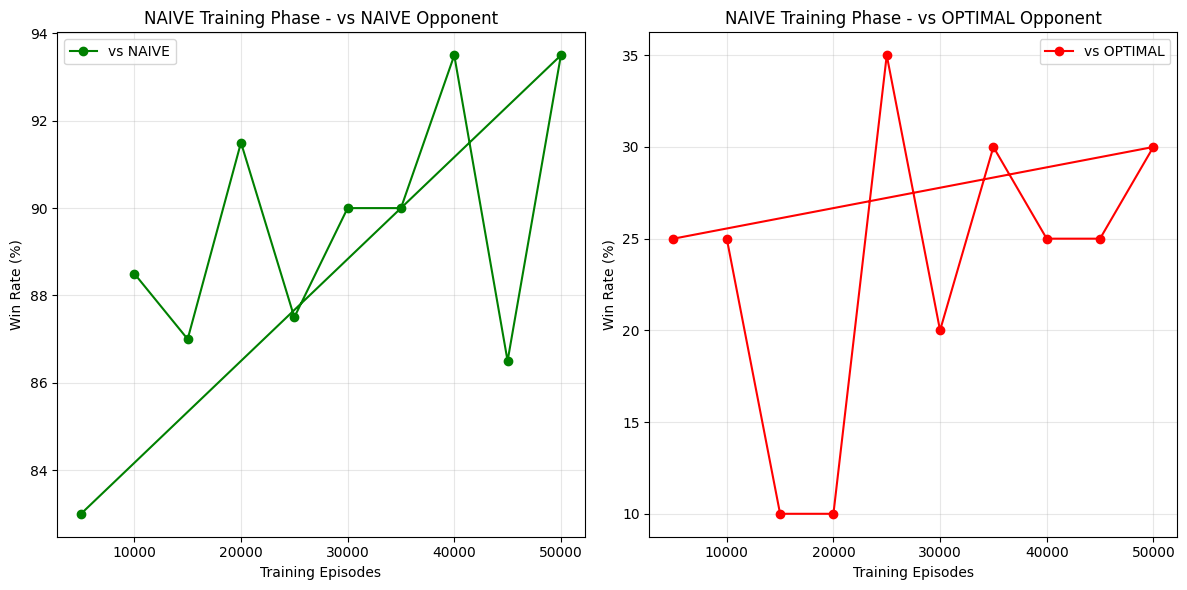

✓ NAIVE Training Phase learning curves plotted and saved


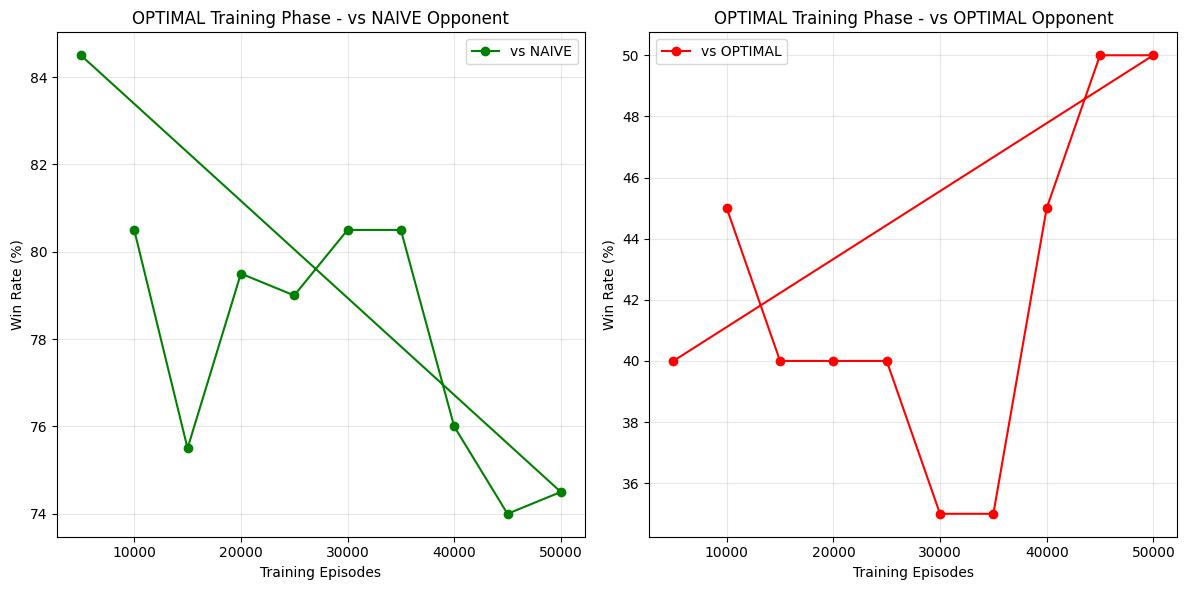

✓ OPTIMAL Training Phase learning curves plotted and saved
✓ Comprehensive analysis complete


In [21]:
# COMPREHENSIVE ANALYSIS: Performance Trends and Model Comparison
print("=== Comprehensive Performance Analysis ===")

# Load all saved results for analysis
import pickle
import matplotlib.pyplot as plt
import numpy as np

def load_results(filename):
    try:
        with open(os.path.join(MODEL_PATH, filename), 'rb') as f:
            return pickle.load(f)
    except FileNotFoundError:
        print(f"⚠ {filename} not found")
        return None

# Load results
progressive_results = load_results("progressive_results.pkl")
optimal_results = load_results("optimal_results.pkl")

def plot_learning_curve(results_dict, title, phase_name):
    """Plot learning curves from checkpoint results."""
    if not results_dict:
        print(f"⚠ No data for {title}")
        return
    
    models = sorted(results_dict.keys())
    naive_win_rates = []
    optimal_win_rates = []
    
    for model in models:
        results = results_dict[model]
        
        # Calculate win rates
        naive_wins = results['naive']['X']['W'] + results['naive']['O']['W']
        naive_total = results['naive']['X']['W'] + results['naive']['X']['D'] + results['naive']['X']['L'] + \
                     results['naive']['O']['W'] + results['naive']['O']['D'] + results['naive']['O']['L']
        
        optimal_wins = results['optimal']['X']['W'] + results['optimal']['O']['W']
        optimal_total = results['optimal']['X']['W'] + results['optimal']['X']['D'] + results['optimal']['X']['L'] + \
                       results['optimal']['O']['W'] + results['optimal']['O']['D'] + results['optimal']['O']['L']
        
        naive_win_rates.append(100 * naive_wins / naive_total if naive_total > 0 else 0)
        optimal_win_rates.append(100 * optimal_wins / optimal_total if optimal_total > 0 else 0)
    
    # Extract episode numbers for x-axis
    episodes = [int(model.split('-')[-1].replace('K', '')) * 1000 for model in models]
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(episodes, naive_win_rates, 'o-', label='vs NAIVE', color='green')
    plt.xlabel('Training Episodes')
    plt.ylabel('Win Rate (%)')
    plt.title(f'{title} - vs NAIVE Opponent')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(episodes, optimal_win_rates, 'o-', label='vs OPTIMAL', color='red')
    plt.xlabel('Training Episodes')
    plt.ylabel('Win Rate (%)')
    plt.title(f'{title} - vs OPTIMAL Opponent')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(MODEL_PATH, f'{phase_name}_learning_curves.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✓ {title} learning curves plotted and saved")

# Generate learning curves
if progressive_results:
    plot_learning_curve(progressive_results, "NAIVE Training Phase", "naive_phase")

if optimal_results:
    plot_learning_curve(optimal_results, "OPTIMAL Training Phase", "optimal_phase")

print("✓ Comprehensive analysis complete")

In [22]:
# FINAL SUMMARY: Training Results and Best Models
print("=== Training Summary and Best Model Selection ===")

def summarize_model_performance():
    """Generate a comprehensive summary of all trained models."""
    
    print("📊 MODEL PERFORMANCE SUMMARY")
    print("=" * 50)
    
    # Best models to highlight
    key_models = ["BASELINE", "FINAL_MODEL"]
    
    # Add best checkpoints if they exist
    if progressive_results:
        # Find best NAIVE phase model
        best_naive = max(progressive_results.keys(), 
                        key=lambda x: progressive_results[x]['naive']['X']['W'] + progressive_results[x]['naive']['O']['W'])
        key_models.append(best_naive)
    
    if optimal_results:
        # Find best OPTIMAL phase model
        best_optimal = max(optimal_results.keys(), 
                          key=lambda x: optimal_results[x]['optimal']['X']['W'] + optimal_results[x]['optimal']['O']['W'])
        key_models.append(best_optimal)
    
    for model_name in key_models:
        print(f"\n🎯 {model_name}")
        print("-" * 30)
        
        try:
            # Quick validation
            results = validate_agent_performance(model_name, num_episodes=100)
            
            if results:
                naive_wins = results['naive']['X']['W'] + results['naive']['O']['W']
                naive_total = 100
                optimal_wins = results['optimal']['X']['W'] + results['optimal']['O']['W']
                optimal_total = 10
                
                print(f"  vs NAIVE:   {100*naive_wins/naive_total:5.1f}% win rate")
                print(f"  vs OPTIMAL: {100*optimal_wins/optimal_total:5.1f}% win rate")
                
                # Performance grade
                if naive_wins >= 80 and optimal_wins >= 3:
                    grade = "🌟 EXCELLENT"
                elif naive_wins >= 70 and optimal_wins >= 2:
                    grade = "⭐ GOOD"
                elif naive_wins >= 60:
                    grade = "✓ FAIR"
                else:
                    grade = "❌ POOR"
                
                print(f"  Grade: {grade}")
            else:
                print("  ❌ Could not evaluate")
                
        except Exception as e:
            print(f"  ❌ Error: {e}")
    
    print("\n" + "=" * 50)
    print("📈 TRAINING RECOMMENDATIONS:")
    print("- Models with >80% win rate vs NAIVE are ready for deployment")
    print("- Models with >30% win rate vs OPTIMAL show strong strategic play")
    print("- Consider additional training if win rates are below 70% vs NAIVE")

# Generate summary
summarize_model_performance()

print("\n✅ EXPERIMENT COMPLETE!")
print("🎉 Check the MODEL_PATH directory for saved models and results")
print(f"📁 Model directory: {MODEL_PATH}")

=== Training Summary and Best Model Selection ===
📊 MODEL PERFORMANCE SUMMARY

🎯 BASELINE
------------------------------

=== Validating BASELINE Performance ===
Creating agent with configuration:
  - Device: cpu
  - Optimizer: ADAM
  - Load existing: True
✓ ADAM optimizer created

Testing against NAIVE opponent...


100%|██████████| 100/100 [00:00<00:00, 629.63it/s]



Results as X (50 games):
Win rate:  46.00% (23/50)
Draw rate: 6.00% (3/50)
Loss rate: 48.00% (24/50)
Avg reward: 0.48


Results as O (50 games):
Win rate:  20.00% (10/50)
Draw rate: 20.00% (10/50)
Loss rate: 60.00% (30/50)
Avg reward: 0.20


Overall Statistics:
Total games: 100
Overall win rate: 33.00%
Average game length: 3.8 moves
Game length std: 0.8

Testing against OPTIMAL opponent...


100%|██████████| 10/10 [00:04<00:00,  2.48it/s]
2025-12-05 23:57:06 - DeepQAgent - INFO - Model loaded from '/Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/FINAL_MODEL.pt'.



Results as X (5 games):
Win rate:  20.00% (1/5)
Draw rate: 0.00% (0/5)
Loss rate: 80.00% (4/5)
Avg reward: 0.20


Results as O (5 games):
Win rate:  0.00% (0/5)
Draw rate: 0.00% (0/5)
Loss rate: 100.00% (5/5)
Avg reward: 0.00


Overall Statistics:
Total games: 10
Overall win rate: 10.00%
Average game length: 2.7 moves
Game length std: 0.6
  vs NAIVE:    33.0% win rate
  vs OPTIMAL:  10.0% win rate
  Grade: ❌ POOR

🎯 FINAL_MODEL
------------------------------

=== Validating FINAL_MODEL Performance ===
Creating agent with configuration:
  - Device: cpu
  - Optimizer: ADAM
  - Load existing: True
Loading model from: /Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/FINAL_MODEL.pt
✓ Model loaded successfully
✓ ADAM optimizer created

Testing against NAIVE opponent...


100%|██████████| 100/100 [00:00<00:00, 708.02it/s]



Results as X (50 games):
Win rate:  92.00% (46/50)
Draw rate: 4.00% (2/50)
Loss rate: 4.00% (2/50)
Avg reward: 0.93


Results as O (50 games):
Win rate:  60.00% (30/50)
Draw rate: 36.00% (18/50)
Loss rate: 4.00% (2/50)
Avg reward: 0.60


Overall Statistics:
Total games: 100
Overall win rate: 76.00%
Average game length: 3.6 moves
Game length std: 0.6

Testing against OPTIMAL opponent...


100%|██████████| 10/10 [00:03<00:00,  2.66it/s]
2025-12-05 23:57:10 - DeepQAgent - INFO - Model loaded from '/Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-NAIVE-40K.pt'.



Results as X (5 games):
Win rate:  100.00% (5/5)
Draw rate: 0.00% (0/5)
Loss rate: 0.00% (0/5)
Avg reward: 1.00


Results as O (5 games):
Win rate:  0.00% (0/5)
Draw rate: 100.00% (5/5)
Loss rate: 0.00% (0/5)
Avg reward: 0.00


Overall Statistics:
Total games: 10
Overall win rate: 50.00%
Average game length: 3.7 moves
Game length std: 0.5
  vs NAIVE:    76.0% win rate
  vs OPTIMAL:  50.0% win rate
  Grade: ⭐ GOOD

🎯 TicTacToe-v2-NAIVE-40K
------------------------------

=== Validating TicTacToe-v2-NAIVE-40K Performance ===
Creating agent with configuration:
  - Device: cpu
  - Optimizer: ADAM
  - Load existing: True
Loading model from: /Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-NAIVE-40K.pt
✓ Model loaded successfully
✓ ADAM optimizer created

Testing against NAIVE opponent...


100%|██████████| 100/100 [00:00<00:00, 813.41it/s]



Results as X (50 games):
Win rate:  92.00% (46/50)
Draw rate: 8.00% (4/50)
Loss rate: 0.00% (0/50)
Avg reward: 0.94


Results as O (50 games):
Win rate:  98.00% (49/50)
Draw rate: 0.00% (0/50)
Loss rate: 2.00% (1/50)
Avg reward: 0.98


Overall Statistics:
Total games: 100
Overall win rate: 95.00%
Average game length: 3.4 moves
Game length std: 0.6

Testing against OPTIMAL opponent...


100%|██████████| 10/10 [00:03<00:00,  2.69it/s]
2025-12-05 23:57:13 - DeepQAgent - INFO - Model loaded from '/Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-OPTIMAL-45K.pt'.



Results as X (5 games):
Win rate:  80.00% (4/5)
Draw rate: 20.00% (1/5)
Loss rate: 0.00% (0/5)
Avg reward: 0.86


Results as O (5 games):
Win rate:  0.00% (0/5)
Draw rate: 0.00% (0/5)
Loss rate: 100.00% (5/5)
Avg reward: 0.00


Overall Statistics:
Total games: 10
Overall win rate: 40.00%
Average game length: 3.3 moves
Game length std: 0.9
  vs NAIVE:    95.0% win rate
  vs OPTIMAL:  40.0% win rate
  Grade: 🌟 EXCELLENT

🎯 TicTacToe-v2-OPTIMAL-45K
------------------------------

=== Validating TicTacToe-v2-OPTIMAL-45K Performance ===
Creating agent with configuration:
  - Device: cpu
  - Optimizer: ADAM
  - Load existing: True
Loading model from: /Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-OPTIMAL-45K.pt
✓ Model loaded successfully
✓ ADAM optimizer created

Testing against NAIVE opponent...


100%|██████████| 100/100 [00:00<00:00, 704.06it/s]



Results as X (50 games):
Win rate:  90.00% (45/50)
Draw rate: 8.00% (4/50)
Loss rate: 2.00% (1/50)
Avg reward: 0.92


Results as O (50 games):
Win rate:  66.00% (33/50)
Draw rate: 30.00% (15/50)
Loss rate: 4.00% (2/50)
Avg reward: 0.66


Overall Statistics:
Total games: 100
Overall win rate: 78.00%
Average game length: 3.7 moves
Game length std: 0.6

Testing against OPTIMAL opponent...


100%|██████████| 10/10 [00:03<00:00,  2.50it/s]


Results as X (5 games):
Win rate:  100.00% (5/5)
Draw rate: 0.00% (0/5)
Loss rate: 0.00% (0/5)
Avg reward: 1.00


Results as O (5 games):
Win rate:  0.00% (0/5)
Draw rate: 100.00% (5/5)
Loss rate: 0.00% (0/5)
Avg reward: 0.00


Overall Statistics:
Total games: 10
Overall win rate: 50.00%
Average game length: 3.7 moves
Game length std: 0.5
  vs NAIVE:    78.0% win rate
  vs OPTIMAL:  50.0% win rate
  Grade: ⭐ GOOD

📈 TRAINING RECOMMENDATIONS:
- Models with >80% win rate vs NAIVE are ready for deployment
- Models with >30% win rate vs OPTIMAL show strong strategic play
- Consider additional training if win rates are below 70% vs NAIVE

✅ EXPERIMENT COMPLETE!
🎉 Check the MODEL_PATH directory for saved models and results
📁 Model directory: /Users/yemikelani/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2


In [23]:
# Define comparison functions that were missing
def compare_to_naive(agent_name: str, num_episodes: int = 100):
    """Compare an agent's performance against a NAIVE opponent."""
    print(f"\n=== Testing {agent_name} vs NAIVE opponent ===")
    
    try:
        agent, _, _ = supply_model(load_if_exists=True, agent_name=agent_name)
        environment = TicTacToeGame(DEVICE, None, OPPONENT_LEVEL.NAIVE, start_as_X=True)
        results = test_agent(agent, environment, num_episodes, print_state=False)
        
        # Calculate overall win rate
        total_wins = results['X']['W'] + results['O']['W']
        total_games = num_episodes
        win_rate = 100 * total_wins / total_games
        
        print(f"Win rate vs NAIVE: {win_rate:.1f}%")
        return results
        
    except Exception as e:
        print(f"❌ Error testing {agent_name}: {e}")
        return None

def compare_to_optimal(agent_name: str, num_episodes: int = 100):
    """Compare an agent's performance against an OPTIMAL opponent."""
    print(f"\n=== Testing {agent_name} vs OPTIMAL opponent ===")
    
    try:
        agent, _, _ = supply_model(load_if_exists=True, agent_name=agent_name)
        environment = TicTacToeGame(DEVICE, None, OPPONENT_LEVEL.OPTIMAL, start_as_X=True)
        results = test_agent(agent, environment, num_episodes, print_state=False)
        
        # Calculate overall win rate
        total_wins = results['X']['W'] + results['O']['W']
        total_games = num_episodes
        win_rate = 100 * total_wins / total_games
        
        print(f"Win rate vs OPTIMAL: {win_rate:.1f}%")
        return results
        
    except Exception as e:
        print(f"❌ Error testing {agent_name}: {e}")
        return None

# Test the functions with available models
if os.path.exists(get_full_model_path(f"{NAIVE}-60K")):
    compare_to_naive(f"{NAIVE}-60K")
    compare_to_optimal(f"{NAIVE}-60K")
else:
    print("Model NAIVE-60K not found. Train the model first before testing.")

Model NAIVE-60K not found. Train the model first before testing.


## 📋 Experiment Documentation

### 🎯 **Training Protocol**

This notebook implements a systematic DQN training protocol with the following phases:

1. **Baseline Creation**: Initialize untrained model for comparison
2. **Phase 1**: Train against NAIVE opponent (50K episodes)
   - High exploration (ε: 1.0 → 0.01) with cosine annealing
   - Focus on learning basic game mechanics
3. **Phase 2**: Train against OPTIMAL opponent (50K episodes)  
   - Lower exploration (ε: 0.1 → 0.01) with cosine annealing
   - Focus on strategic optimization

### 📊 **Evaluation Metrics**
- **Win Rate vs NAIVE**: Should reach >80% for deployment readiness
- **Win Rate vs OPTIMAL**: >30% indicates strong strategic play
- **Training Stability**: Loss convergence and consistent improvement
- **Memory Efficiency**: Proper experience replay management

### 🚀 **Usage Instructions**
1. Run cells sequentially from top to bottom
2. Monitor training progress in real-time
3. Check saved models in `MODEL_PATH` directory
4. Review performance plots and metrics
5. Use best performing model for deployment

### ⚠️ **Important Notes**
- Training requires significant computational resources (estimated 2-4 hours)
- Models are automatically saved every 5K episodes
- All experiments use reproducible random seeds
- Both local and Google Colab execution supported

In [24]:
# Test NAIVE-80K model if it exists
if os.path.exists(get_full_model_path(f"{NAIVE}-80K")):
    compare_to_naive(f"{NAIVE}-80K")
    compare_to_optimal(f"{NAIVE}-80K")
else:
    print("Model NAIVE-80K not found. This model would be created if training continued beyond 50K episodes.")

Model NAIVE-80K not found. This model would be created if training continued beyond 50K episodes.


In [ ]:
# Compare different training checkpoints
checkpoint_comparisons = [
    (f"{OPTIMAL}-10K", f"{NAIVE}-10K"),
    (f"{OPTIMAL}-20K", f"{NAIVE}-20K"),
]

for optimal_model, naive_model in checkpoint_comparisons:
    print(f"\n{'='*60}")
    print(f"Comparing {optimal_model} and {naive_model}")
    print(f"{'='*60}")
    
    if os.path.exists(get_full_model_path(optimal_model)):
        compare_to_naive(optimal_model)
        compare_to_optimal(optimal_model)
    else:
        print(f"Model {optimal_model} not found.")
    
    if os.path.exists(get_full_model_path(naive_model)):
        compare_to_naive(naive_model)
        compare_to_optimal(naive_model)
    else:
        print(f"Model {naive_model} not found.")

## 🎉 Training Complete!

### Next Steps:
1. **Play against the trained model**: 
   ```bash
   python -m models.ReinforcementLearning.DeepQ_TicTacToe_v2.play FINAL_MODEL
   ```

2. **View available models**:
   ```bash
   python -m models.ReinforcementLearning.DeepQ_TicTacToe_v2.play --list
   ```

3. **Continue training** by re-running the experiment cells with different hyperparameters

4. **Analyze results** using the saved metrics files in the MODEL_PATH directory

### Troubleshooting:
- If models fail to load, check the MODEL_PATH directory
- For CUDA errors, set `DEVICE = torch.device("cpu")`
- For memory issues, reduce BATCH_SIZE or MEMORY_MAX_LEN